W tym projekcie skupię się na zagadnieniu klasyfikacji. Posłuży mi do tego baza danych zbudowana w notatniku dostępnym pod adresem: https://colab.research.google.com/drive/1tYcppW8hd1bCUmyQME2c_Kx6h25IucUN. Baza ta skupia zawodników z pięciu największych lig europejskich: Premier League (Anglia), Serie A (Włochy), Bundesligi (Niemcy), Ligue 1 (Francja) oraz La Liga (Hiszpania) i ich statystyki meczowe za sezon 2020/21. W pierwszej części dokonam klasyfikacji binarnej na napastników i graczy z pozostałych pozycji, w drugiej - postaram się dokonać klasyfikacji wszystkich zawodników wg ich pozycji.

#Import bibliotek.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

#Załadowanie przygotowanej bazy danych.

In [2]:
!git clone 'https://gitlab.com/jakub_walczak/players-classification-season-2020-21'
df = pd.read_csv('players-classification-season-2020-21/Top5leagues.csv')

fatal: destination path 'players-classification-season-2020-21' already exists and is not an empty directory.


In [3]:
df.head()

,Name,Age,Height,Weight,Position,Apps,Total minutes,Scored goals,Assists,Total shots,...,Fouls drawn,Fouls committed,Yellow cards,Red cards for 2nd yellow,Straight red cards,Penalties won,Penalties scored,Penalties missed,Penalties committed,Penalties saved
0,S. Agüero,33,173 cm,70 kg,Attacker,12.0,559.0,4.0,1.0,17.0,...,7.0,2.0,0.0,0.0,0.0,NaN,1.0,1.0,NaN,NaN
1,Lee Grant,39,193 cm,83 kg,Goalkeeper,0.0,0.0,0.0,NaN,NaN,...,NaN,NaN,0.0,0.0,0.0,NaN,0.0,0.0,NaN,0.0
2,B. Ivanović,37,185 cm,89 kg,Defender,13.0,765.0,0.0,NaN,3.0,...,4.0,11.0,2.0,0.0,0.0,NaN,0.0,0.0,NaN,NaN
3,Gary Cahill,37,193 cm,86 kg,Defender,20.0,1800.0,1.0,1.0,8.0,...,3.0,12.0,3.0,0.0,0.0,NaN,0.0,0.0,NaN,NaN
4,G. Sigurðsson,33,186 cm,79 kg,Midfielder,36.0,2255.0,6.0,5.0,33.0,...,18.0,22.0,2.0,0.0,0.0,NaN,3.0,1.0,NaN,NaN


Już w pierwszych kolumnach uwidacznia się, że baza zawiera znaczną liczbę rekordów NaN, które trzeba w odpowiedni sposób wypełnić. Sprawdźmy więc liczbę nie-NaN-ów w poszczególnych kolumnach za pomocą funkcji pandas.DataFrame.info:

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3701 entries, 0 to 3700
Data columns (total 33 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Name                      3701 non-null   object 
 1   Age                       3701 non-null   int64  
 2   Height                    3391 non-null   object 
 3   Weight                    3162 non-null   object 
 4   Position                  3701 non-null   object 
 5   Apps                      3685 non-null   float64
 6   Total minutes             3685 non-null   float64
 7   Scored goals              3685 non-null   float64
 8   Assists                   1246 non-null   float64
 9   Total shots               2234 non-null   float64
 10  Shots on goal             1964 non-null   float64
 11  Duels total               2696 non-null   float64
 12  Duels won                 2624 non-null   float64
 13  Dribble attempts          2342 non-null   float64
 14  Dribbles

Okazuje się, że liczba NaN-ów jest znaczna, w niektórych kolumnach stanowi nawet niemal wszystkie rekordy. Co więcej, kolumny "Height" i "Weight" zawierają dane typu string (object), ze względu na dodanie na końcu każdego rekordu jednostki miary.

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,3701.0,26.643340,4.988452,17.0,22.0,26.0,30.00,50.0
Apps,3685.0,14.350068,13.127956,0.0,0.0,13.0,27.00,38.0
Total minutes,3685.0,952.512619,1021.158726,0.0,0.0,559.0,1764.00,3420.0
Scored goals,3685.0,1.305563,3.020377,0.0,0.0,0.0,1.00,41.0
Assists,1246.0,2.674157,2.272537,1.0,1.0,2.0,3.00,18.0
Total shots,2234.0,14.300806,15.904184,0.0,4.0,9.0,19.00,141.0
Shots on goal,1964.0,7.586049,9.082361,0.0,2.0,4.0,10.00,91.0
Duels total,2696.0,138.903190,118.242846,0.0,31.0,120.0,221.00,692.0
Duels won,2624.0,71.331174,60.467808,0.0,19.0,61.0,111.00,379.0
Dribble attempts,2342.0,24.549957,27.814035,0.0,5.0,15.0,33.00,247.0


Powyższe obserwacje potwierdzają również podstawowe statystyki opisowe. Zwróćmy też uwagę, iż dla znacznej części kolumn, w tym kolumny "Apps" przedstawiającej liczbę rozegranych meczów, pierwszy kwartyl przyjmuje wartość 0. Ponieważ chcemy klasyfikator oprzeć głównie na statystykach w poszczególnych elementach gry, trzeba będzie przyjąć pewien próg łącznie rozegranych minut, poniżej których nie klasyfikuję graczy. Tym progiem będzie 270 minut, czyli trzy pełne rozegrane mecze.

In [6]:
df.columns

Index(['Name', 'Age', 'Height', 'Weight', 'Position', 'Apps', 'Total minutes',
       'Scored goals', 'Assists', 'Total shots', 'Shots on goal',
       'Duels total', 'Duels won', 'Dribble attempts', 'Dribbles succ.',
       'Total duels', 'Total passes', 'Key passes', 'Tackles', 'Blocks',
       'Interceptions', 'Total saves', 'Goals conceded', 'Fouls drawn',
       'Fouls committed', 'Yellow cards', 'Red cards for 2nd yellow',
       'Straight red cards', 'Penalties won', 'Penalties scored',
       'Penalties missed', 'Penalties committed', 'Penalties saved'],
      dtype='object')

Przystępujemy do "obróbki" bazy danych. Zacznijmy od przekształcenia danych w kolumnach "Height" i "Weight" na wartości liczbowe typu float poprzez usunięcie jednostki miary i rzutowanie wyniku.

In [7]:
df['Height'] =  df['Height'].str.replace("\D", "", regex = True).astype(float)
df['Weight'] = df['Weight'].str.replace("\D", "", regex = True).astype(float)

In [8]:
df.isnull().any()

Name                        False
Age                         False
Height                       True
Weight                       True
Position                    False
Apps                         True
Total minutes                True
Scored goals                 True
Assists                      True
Total shots                  True
Shots on goal                True
Duels total                  True
Duels won                    True
Dribble attempts             True
Dribbles succ.               True
Total duels                  True
Total passes                 True
Key passes                   True
Tackles                      True
Blocks                       True
Interceptions                True
Total saves                  True
Goals conceded               True
Fouls drawn                  True
Fouls committed              True
Yellow cards                 True
Red cards for 2nd yellow     True
Straight red cards           True
Penalties won                True
Penalties scor

Na potrzeby likwidacji wartości NaN przyjmę następującą konwencję:
- wartości w kolumnach dot. statystyk meczowych zastępować będę zerem,
- wartości w kolumnach dot. wzrostu i wagi zastąpię medianą z tych kolumn. 

Da się bowiem przyjąć, że piłkarz może nie zanotować osiągów w jakimś elemencie gry, ale przyjęcie wzrostu lub wagi na poziomie 0 może prowadzić do karykaturalnych wyników.

In [9]:
df['Weight'].fillna((df['Weight'].median()), inplace=True)
df['Height'].fillna((df['Height'].median()), inplace=True)

In [10]:
df.fillna(0, inplace=True)

Usuwam kolumnę "Name" (bo nazwiska piłkarzy nam się do niczego nie przydadzą) i "Duels total" (bo została błędnie dodana jako duplikat kolumny "Total duels" przy budowaniu bazy).

In [11]:
df.drop(columns=['Name', 'Duels total'], axis = 1, inplace=True)

Zgodnie z przyjętym wyżej progiem, usuwam zawodników poniżej 90 rozegranych minut.

In [12]:
df = df[df['Total minutes']>=270]

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2129 entries, 0 to 3696
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       2129 non-null   int64  
 1   Height                    2129 non-null   float64
 2   Weight                    2129 non-null   float64
 3   Position                  2129 non-null   object 
 4   Apps                      2129 non-null   float64
 5   Total minutes             2129 non-null   float64
 6   Scored goals              2129 non-null   float64
 7   Assists                   2129 non-null   float64
 8   Total shots               2129 non-null   float64
 9   Shots on goal             2129 non-null   float64
 10  Duels won                 2129 non-null   float64
 11  Dribble attempts          2129 non-null   float64
 12  Dribbles succ.            2129 non-null   float64
 13  Total duels               2129 non-null   float64
 14  Total pa

W ten sposób pozbyliśmy się NaN-ów oraz zbędnych kolumn tekstowych, baza danych jest zatem przygotowana do tworzenia modeli. Zgodnie z założeniami jedyną kolumną tekstową jest kolumna "Position", która służyć nam będzie do klasyfikacji graczy.

In [14]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,2129.0,26.753405,4.864785,17.0,23.0,26.0,30.0,50.0
Height,2129.0,182.511508,6.548043,156.0,178.0,183.0,187.0,202.0
Weight,2129.0,75.951151,6.781738,55.0,72.0,76.0,80.0,100.0
Apps,2129.0,23.858149,8.910983,3.0,17.0,25.0,31.0,38.0
Total minutes,2129.0,1623.070456,858.337127,270.0,882.0,1566.0,2326.0,3420.0
Scored goals,2129.0,2.240019,3.701526,0.0,0.0,1.0,3.0,41.0
Assists,2129.0,1.528417,2.191119,0.0,0.0,1.0,2.0,18.0
Total shots,2129.0,14.478628,16.112318,0.0,4.0,9.0,19.0,141.0
Shots on goal,2129.0,6.768906,8.945856,0.0,1.0,4.0,9.0,91.0
Duels won,2129.0,85.060122,58.323364,0.0,37.0,76.0,123.0,379.0


Sprawdzamy rozkład zmiennych kategoryzujących dot. pozycji. Zdecydowanie najliczniejsi (i bardzo zbliżeni pod względem liczebności) są obrońcy i pomocnicy, o ok. 1/3 mniej jest napastników, a zdecydowanie najmniejszą grupę stanowią bramkarze (circa pięciokrotnie mniej liczną niż pomocnicy czy obrońcy).

In [15]:
df.Position.value_counts(dropna=False, normalize=True)

Defender      0.362612
Midfielder    0.348520
Attacker      0.217003
Goalkeeper    0.071865
Name: Position, dtype: float64

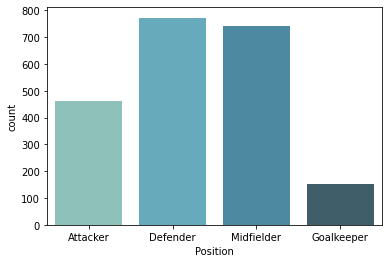

In [16]:
sns.countplot(x='Position',data=df, palette='GnBu_d')
plt.show()

Sprawdźmy teraz statystyki opisowe dla każdej z pozycji, w czym pomoże nam tabela piwotalna.

Separowalność klas dobrze sprawdzić w kolumnach dot. średnich wartości. Najlepiej pod tym względem sprawdzają się zmienne dot. statystyk typowych dla graczy ofensywnych ("Dribble attempts", "Dribble succ.", "Scored goals", "Shots on goal", "Total shots") czy stricte defensywnych ("Blocks", "Interceptions") oraz zmienna dot. całkowitej liczby podań ("Total passes"). 

Statystyki pomocników, z uwagi na swoistą "pośredniość" ustawienia na boisku, bywają zbliżone bądź to do napastników (np. "Assists", "Key passes") bądź obrońców (m.in. "Yellow cards", "Tackles"), bądź jednych i drugich (np. "Duels won"). 

Praktycznie każda kolumna zapewnia separowalność bramkarzy od zawodników z pozostałych pozycji. Kolumny "Apps", "Height", "Weight" nie pozwalają z kolei na dostateczny podział wg etykiet.

In [17]:
pivot = pd.pivot_table(df, index='Position', values = ['Height', 'Weight','Apps', 'Total minutes',
       'Scored goals', 'Assists', 'Total shots', 'Shots on goal',
       'Duels won', 'Dribble attempts', 'Dribbles succ.',
       'Total duels', 'Total passes', 'Key passes', 'Tackles', 'Blocks',
       'Interceptions', 'Total saves', 'Goals conceded', 'Fouls drawn',
       'Fouls committed', 'Yellow cards', 'Red cards for 2nd yellow',
       'Straight red cards', 'Penalties won', 'Penalties scored',
       'Penalties missed', 'Penalties committed', 'Penalties saved'], aggfunc= [np.mean, np.median, min, max, np.std])
pd.options.display.max_columns = None
display(pivot)

mean                                                      \
                 Apps   Assists    Blocks Dribble attempts Dribbles succ.   
Position                                                                    
Attacker    25.701299  2.448052  1.134199        42.103896      22.909091   
Defender    22.290155  0.918394  9.051813        15.900259       9.641192   
Goalkeeper  22.692810  0.045752  0.000000         0.411765       0.385621   
Midfielder  24.582210  1.896226  3.407008        31.894879      19.494609   

                                                                              \
            Duels won Fouls committed Fouls drawn Goals conceded      Height   
Position                                                                       
Attacker    93.183983       22.043290   26.597403       0.000000  181.913420   
Defender    88.470207       20.005181   14.996114       0.000000  182.389896   
Goalkeeper   8.352941        0.516340    2.633987      31.117647  183.483660   
Midfielder  92.270889       24.242588   23.111860       0.000000  182.809973   

                                                                          \
           Interceptions Key passes Penalties committed Penalties missed   
Position                                                                   
Attacker        7.207792  19.889610            0.000000         0.173160   
Defender       27.601036   9.639896            0.006477         0.002591   
Goalkeeper      0.712418   0.372549            0.000000         0.006536   
Midfielder     19.974394  19.179245            0.000000         0.059299   

                                                           \
           Penalties saved Penalties scored Penalties won   
Position                                                    
Attacker          0.000000         0.703463      0.004329   
Defender          0.000000         0.023316      0.002591   
Goalkeeper        0.856209         0.006536      0.000000   
Midfielder        0.000000         0.252022      0.000000   

                                                                \
           Red cards for 2nd yellow Scored goals Shots on goal   
Position                                                         
Attacker                   0.036797     5.764069     15.668831   
Defender                   0.081606     0.835492      2.838083   
Goalkeeper                 0.000000     0.013072      0.026144   
Midfielder                 0.063342     1.966307      6.707547   

                                                                    \
           Straight red cards    Tackles Total duels Total minutes   
Position                                                             
Attacker             0.067100  14.627706  210.203463   1480.787879   
Defender             0.098446  29.908031  158.687824   1691.441710   
Goalkeeper           0.065359   0.549020   10.248366   2028.222222   
Midfielder           0.084906  31.231806  188.880054   1556.983827   

                                                                         \
           Total passes Total saves Total shots     Weight Yellow cards   
Position                                                                  
Attacker     436.430736    0.000000   29.683983  75.218615     2.283550   
Defender     924.195596    0.000000    7.647668  75.878238     3.563472   
Goalkeeper   650.869281   62.359477    0.058824  76.627451     0.862745   
Midfielder   790.203504    0.000000   15.091644  76.343666     3.638814   

           median                                                           \
             Apps Assists Blocks Dribble attempts Dribbles succ. Duels won   
Position                                                                     
Attacker     27.0     2.0    1.0             29.0           16.0      83.0   
Defender     23.0     0.0    6.0             10.0            6.0      82.0   
Goalkeeper   28.0     0.0    0.0              0.0            0.0       8.0   
Midfiel

Heatmap wskazuje wyraźnie, iż znaczna część zmiennych pozostaje w wysokiej korelacji dodatniej. Stwórzmy również funkcję wyświetlającą wszystkie zmienne o korelacji wyższej niż podany próg wg skali Pearsona.

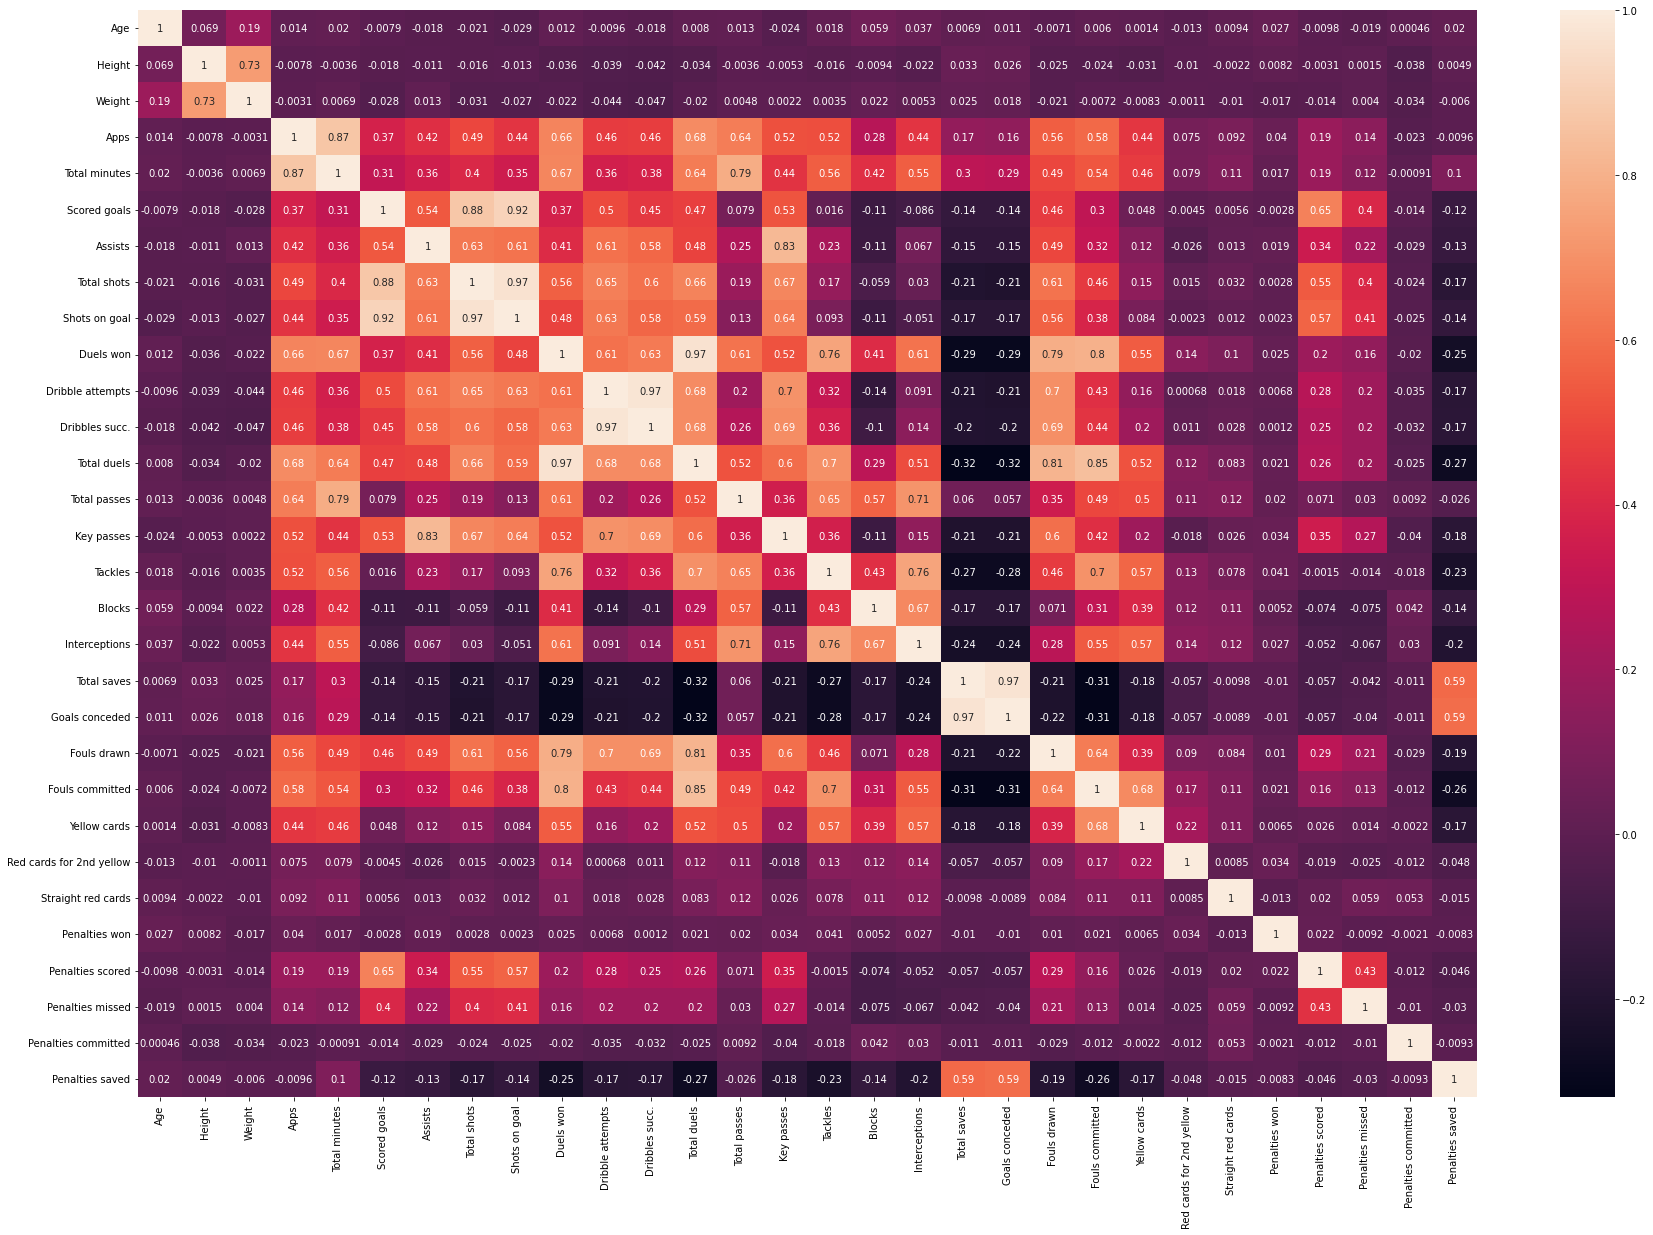

In [18]:
cm = df.corr()
fig, ax = plt.subplots(figsize=(30,20))
sns.heatmap(cm, annot=True)

In [19]:
def corrFilter(x: pd.DataFrame, y: float):
    xCorr = x.corr()
    xFiltered = xCorr[((xCorr >= y) | (xCorr <= -y)) & (xCorr !=1.000)]
    xFlattened = xFiltered.unstack().sort_values(ascending=False).drop_duplicates().dropna()
    return xFlattened

corrFilter(df, .7)

Dribbles succ.   Dribble attempts    0.974340
Total saves      Goals conceded      0.972702
Total shots      Shots on goal       0.966504
Duels won        Total duels         0.965733
Scored goals     Shots on goal       0.915291
Total shots      Scored goals        0.875098
Total minutes    Apps                0.870750
Total duels      Fouls committed     0.845609
Assists          Key passes          0.825223
Fouls drawn      Total duels         0.809911
Fouls committed  Duels won           0.803798
Fouls drawn      Duels won           0.792004
Total passes     Total minutes       0.785303
Tackles          Duels won           0.758761
                 Interceptions       0.757726
Weight           Height              0.733962
Total passes     Interceptions       0.709180
Key passes       Dribble attempts    0.703386
Fouls committed  Tackles             0.701445
Tackles          Total duels         0.700325
dtype: float64

#Napastnicy wśród zawodników z innych pozycji - klasyfikacja binarna.

##Przygotowanie i podział zbiorów, redukcja wymiarów.

Naturalnie rozpocząć powinniśmy od zdefiniowania zbiorów X: zmiennych zależnych (dotyczących statystyk meczowych) i Y: etykiet (pozycji graczy). Zbiory stworzymy bardzo prosto: X - poprzez usunięcie kolumny "Position", Y - poprzez wyodrębnienie kolumny "Position", a następnie poprzez przypisanie tychże do tak nazwanych zmiennych.

In [20]:
X = df.drop(columns='Position')
Y = df['Position']

In [21]:
print(X.head())

   Age  Height  Weight  Apps  Total minutes  Scored goals  Assists  \
0   33   173.0    70.0  12.0          559.0           4.0      1.0   
2   37   185.0    89.0  13.0          765.0           0.0      0.0   
3   37   193.0    86.0  20.0         1800.0           1.0      1.0   
4   33   186.0    79.0  36.0         2255.0           6.0      5.0   
6   35   180.0    70.0  21.0          705.0           0.0      0.0   

   Total shots  Shots on goal  Duels won  Dribble attempts  Dribbles succ.  \
0         17.0           12.0       21.0              13.0             8.0   
2          3.0            1.0       31.0               0.0             0.0   
3          8.0            3.0       86.0               1.0             1.0   
4         33.0           17.0       67.0              26.0            14.0   
6          1.0            0.0       21.0               2.0             2.0   

   Total duels  Total passes  Key passes  Tackles  Blocks  Interceptions  \
0         51.0         171.0      

In [22]:
Y

0         Attacker
2         Defender
3         Defender
4       Midfielder
6       Midfielder
           ...    
3692      Defender
3693      Defender
3694    Midfielder
3695      Defender
3696    Midfielder
Name: Position, Length: 2129, dtype: object

Na zbiorze Y wykonamy prosty encoding przy pomocy funkcji numpy.where - rekordy dot. napastników zmienimy na 1, dot. innych pozycji - na 0.

In [23]:
y = np.where(Y == 'Attacker', 1, 0)

In [24]:
y

array([1, 0, 0, ..., 0, 0, 0])

Sprawdźmy teraz, jak rozkładają się zadane klasy.

In [25]:
np.unique(y, return_counts=True)

(array([0, 1]), array([1667,  462]))

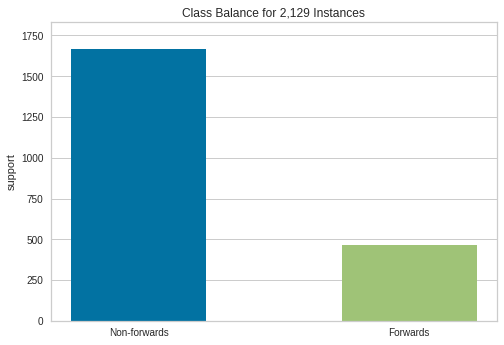

ClassBalance(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f32590dc250>,
             labels=['Non-forwards', 'Forwards'])

In [26]:
from yellowbrick.target import class_balance

class_balance(y.flatten(), labels=['Non-forwards', 'Forwards'])

Train test splitem dokonamy podziału na zbiór treningowy (65,7% rekordów) i testowy (33,3%). Parametr stratify pozwoli na zachowanie równego balansu klas w obu zbiorach.

In [27]:
from sklearn.model_selection import train_test_split, GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.333,
                                                    random_state = 42,
                                                    stratify=y)

In [28]:
print(np.unique(y_train, return_counts=True))
print(np.unique(y_test, return_counts=True))

(array([0, 1]), array([1112,  308]))
(array([0, 1]), array([555, 154]))


###PCA.

Baza danych, na której pracujemy, zawiera dużą liczbę zmiennych numerycznych (30), w znacznym stopniu skorelowanych. Aby zredukować liczbę zmiennych i korelacji, przydatnym narzędziem będzie PCA - Principal Component Analysis.

Operację z użyciem PCA dokonać należy na danych już zestandaryzowanych. Poszczególne cechy prezentują bowiem różny rząd wysokości, a pożądanym będzie zachowanie równoważności cech.

Text(0, 0.5, 'variance')

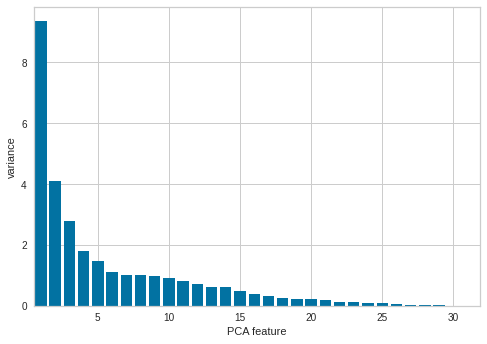

In [29]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

pca = PCA()

X_train_pca = pca.fit_transform(X_train_sc)
X_test_pca = pca.transform(X_test_sc)

features = range(1, pca.n_components_+1)
plt.bar(features, pca.explained_variance_)
plt.xlim(xmin=0.5)
plt.xlabel('PCA feature')
plt.ylabel('variance')

Jak widać, wariancja gwałtownie spada już przy pierwszych 4 cechach. Bardzo wysokie wyjaśnienie wariancji ma jednak z kolei miejsce dopiero przy użyciu mniej więcej 15-17. cechy. Powyżej 20. cechy wyjaśnienie wariancji jest natomiast znikome.

In [30]:
pca.explained_variance_ratio_

array([0.3118294 , 0.13716747, 0.09240128, 0.06005277, 0.04895419,
       0.03687304, 0.03403008, 0.03361483, 0.0322057 , 0.03032683,
       0.02697981, 0.02403003, 0.02078266, 0.02045073, 0.01604399,
       0.01287344, 0.0111751 , 0.00854886, 0.00775481, 0.00750898,
       0.00667266, 0.00470535, 0.00404231, 0.00331157, 0.00291617,
       0.00196683, 0.0008782 , 0.0008571 , 0.00071746, 0.00032833])

Ponownie wytrenujmy zatem PCA, tym razem przy użyciu parametru n_components równego 17.

In [31]:
pca = PCA(n_components=20)

X_train_sc = pca.fit_transform(X_train_sc)
X_test_sc = pca.transform(X_test_sc)

print(X_train_sc.shape)

(1420, 20)


Text(0, 0.5, 'variance')

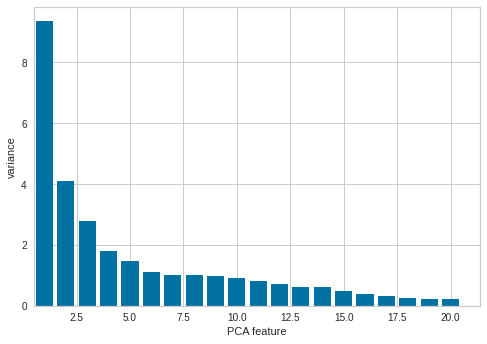

In [32]:
features = range(1, pca.n_components_+1)
plt.bar(features, pca.explained_variance_)
plt.xlim(xmin=0.5)
plt.xlabel('PCA feature')
plt.ylabel('variance')

Pierwszych 20 cech wyjaśnia ok. 97,3% całości wariancji. Taka liczba zmiennych w zupełności wystarczy do stworzenia modeli zarówno wystarczająco szybkich, ale i dokładnych.

In [33]:
np.sum(pca.explained_variance_ratio_)

0.9736040247522278

In [34]:
X_train_sc

array([[ 3.41952223e+00, -2.40311009e+00,  4.44961188e-01, ...,
         1.80698965e-01, -8.30134018e-01,  2.33690264e-03],
       [-2.92067440e+00,  7.60543268e-01, -1.02201339e+00, ...,
         5.26913455e-01, -3.63624827e-01,  6.24105085e-02],
       [-3.54677104e+00,  1.43278104e+00, -1.26535300e+00, ...,
         3.39229924e-01, -2.23299465e-01,  4.86210532e-01],
       ...,
       [ 1.56448888e-01,  4.30137638e-01, -5.19570613e-01, ...,
         4.52276313e-01,  8.30982460e-02, -1.20209932e+00],
       [ 2.13482482e+00, -3.45787182e+00,  1.02150179e+00, ...,
        -1.32314049e+00,  3.65586548e-01,  3.46232686e-01],
       [ 1.48332204e+00,  5.55846979e-01, -3.90585067e-01, ...,
         1.17706283e-01, -9.46585272e-02,  5.16063599e-02]])

In [35]:
X_test_sc

array([[-0.34651465, -1.10504331, -0.5984194 , ...,  0.20498711,
         0.35536172,  0.26915699],
       [-3.39861163,  0.16180681, -0.89072034, ...,  0.20666177,
        -0.25991931, -0.05706683],
       [-0.18499028, -2.42169029,  0.38203759, ..., -0.25931668,
        -0.11640175, -0.86248828],
       ...,
       [-2.73663047, -0.21276644, -1.0897986 , ...,  0.13117252,
         0.34399646, -0.02766175],
       [-0.92981665,  0.83470843, -0.81503642, ..., -0.16490851,
         0.58443592, -0.35882437],
       [-1.45149114,  1.19112858, -0.67342077, ...,  0.51648068,
        -0.27501805, -0.75374655]])

##Modelowanie.

Na potrzeby modelowania przyjąłem konwencję, wg której hiperparametry do każdego modelu będę dopasowywać przy użyciu zaimportowanej wcześniej funkcji GridSearchCV. Pomoże ona w sprawdzeniu różnych kombinacji parametrów i przeprowadzeniu walidacji krzyżowej. Aby przy tym poszczególne modele działały dosyć szybko, słowniki parametrów nie będą zbyt obszerne i sprowadzać się będą do maksymalnie czterech kluczy.

###Regresja logistyczna.

Regresję logistyczną wytrenujmy, testując od razu różne stopnie wielomianu - pierwszy, drugi, trzeci - oraz parametr C, który możemy określić jako współczynnik kary za błędną klasyfikację. Importujemy funkcje LogisticRegression (dla stworzenia modelu regresji logistycznej) i Pipeline (aby od razu utworzyć sekwencję operacji w modelu).

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ('poly', PolynomialFeatures()),
    ('lr', LogisticRegression(warm_start=True, max_iter=50000))
])

params = {'poly__degree': [1, 2, 3], 'lr__C': [0.01, 1, 10, 100]}
gs = GridSearchCV(pipe, param_grid=params, cv=10, verbose=10)
gs.fit(X_train_sc, y_train)
lr_train_pred = gs.predict(X_train_sc)

Fitting 10 folds for each of 12 candidates, totalling 120 fits
[CV 1/10; 1/12] START lr__C=0.01, poly__degree=1................................
[CV 1/10; 1/12] END .lr__C=0.01, poly__degree=1;, score=0.915 total time=   0.0s
[CV 2/10; 1/12] START lr__C=0.01, poly__degree=1................................
[CV 2/10; 1/12] END .lr__C=0.01, poly__degree=1;, score=0.859 total time=   0.0s
[CV 3/10; 1/12] START lr__C=0.01, poly__degree=1................................
[CV 3/10; 1/12] END .lr__C=0.01, poly__degree=1;, score=0.887 total time=   0.0s
[CV 4/10; 1/12] START lr__C=0.01, poly__degree=1................................
[CV 4/10; 1/12] END .lr__C=0.01, poly__degree=1;, score=0.908 total time=   0.0s
[CV 5/10; 1/12] START lr__C=0.01, poly__degree=1................................
[CV 5/10; 1/12] END .lr__C=0.01, poly__degree=1;, score=0.859 total time=   0.0s
[CV 6/10; 1/12] START lr__C=0.01, poly__degree=1................................
[CV 6/10; 1/12] END .lr__C=0.01, poly__degree=

Model sprawdził się najlepiej z pierwszym stopniem wielomianu i przy równej 100 wartości parametru C. Jako najlepszy wynik iteracji GridSearch wskazuje ok. 0.925, czyli całkiem wysoki.

In [37]:
print(gs.best_params_)
print(gs.best_estimator_)
print(gs.best_score_)

{'lr__C': 100, 'poly__degree': 1}
Pipeline(steps=[('poly', PolynomialFeatures(degree=1)),
                ('lr',
                 LogisticRegression(C=100, max_iter=50000, warm_start=True))])
0.9253521126760564


In [38]:
print(classification_report(y_train, lr_train_pred, zero_division=1))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95      1112
           1       0.86      0.81      0.83       308

    accuracy                           0.93      1420
   macro avg       0.90      0.89      0.89      1420
weighted avg       0.93      0.93      0.93      1420



Model zanotował bardzo dobre wyniki na zbiorze treningowym, jeśli chodzi o klasyfikację nie-napastników - na 1112 poprawnie przypisał 1070 rekordów. Słabiej poszło natomiast z napastnikami - wartości True Positive i False Negative wynoszą odpowiednio 249 i 59.

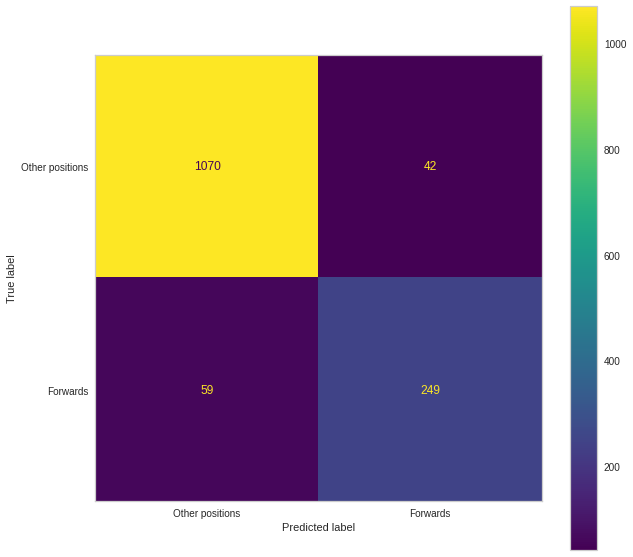

In [39]:
cf_matrix = confusion_matrix(y_train, lr_train_pred)
cmd = ConfusionMatrixDisplay(cf_matrix, display_labels=['Other positions', 'Forwards'])

fig, ax = plt.subplots(figsize=(10,10))
cmd.plot(ax=ax)
plt.grid(False)
plt.show()

Zbudujmy przy okazji listę wyników dokładności na zbiorze treningowym, którą rozszerzać będziemy przy testowaniu każdego modelu. Będzie to przydatne do podsumowania.

In [40]:
train_scores = []
train_scores.append(lr_train_pred)

Przejdźmy do ewaluacji modelu na zbiorze testowym.

In [41]:
lr_test_pred = gs.predict(X_test_sc)

Ze zbiorem testowym model radzi sobie minimalnie słabiej. Dokładność (accuracy) spadła z 0,93 na 0,92, wszystkie pozostałe wyniki również są niższe o jedną-dwie setne. Model należy jednak ocenić dosyć pozytywnie.

In [42]:
print(classification_report(y_test, lr_test_pred, zero_division=1))

              precision    recall  f1-score   support

           0       0.94      0.95      0.95       555
           1       0.81      0.80      0.81       154

    accuracy                           0.92       709
   macro avg       0.88      0.87      0.88       709
weighted avg       0.92      0.92      0.92       709



Powyższą obserwację potwierdza matryca pomyłek. Przy zbiorze ponad dwukrotnie mniejszym model odnotowuje o nieco mniej niż połowę liczbę błędnych przypisań.

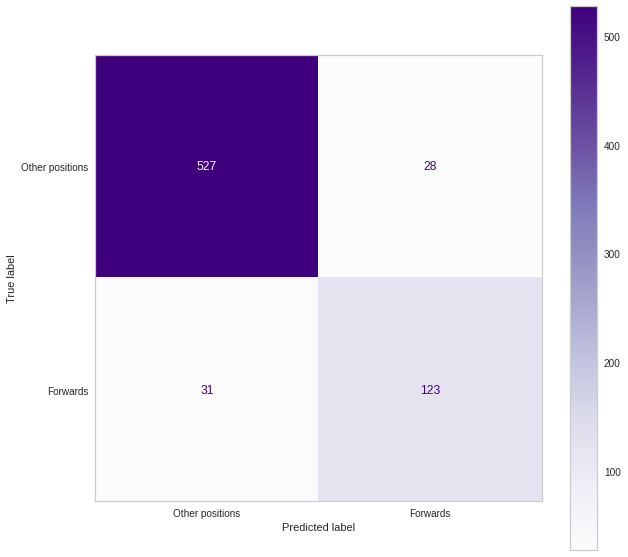

In [43]:
cf_matrix = confusion_matrix(y_test, lr_test_pred)
cmd = ConfusionMatrixDisplay(cf_matrix, display_labels=['Other positions', 'Forwards'])

fig, ax = plt.subplots(figsize=(10,10))
cmd.plot(ax=ax, cmap='Purples')
plt.grid(False)
plt.show()

Analogicznie do zbioru treningowego, zbudujmy listę metryk dokładności dla zbioru testowego.

In [44]:
test_scores = []
test_scores.append(lr_test_pred)

###Maszyny wektorów nośnych (SVM).

####Kernele jednomianowe.

Ponieważ ten model działa szybciej, do SVM dobiorę więcej wartości parametru C. GridSearchCV sprawdzi również, który z kerneli - linearny, gaussowski czy sigmoidalny - będzie klasyfikować najlepiej.

In [45]:
from sklearn.svm import SVC

params = {'C': [0.01, 1, 2, 10, 25, 50, 100], 'kernel': ['linear', 'rbf', 'sigmoid']}
svc = SVC(probability=True)
gs = GridSearchCV(svc, param_grid=params, cv=10, verbose=10)
gs.fit(X_train_sc, y_train)
svm_train_pred = gs.predict(X_train_sc)

Fitting 10 folds for each of 21 candidates, totalling 210 fits
[CV 1/10; 1/21] START C=0.01, kernel=linear.....................................
[CV 1/10; 1/21] END ......C=0.01, kernel=linear;, score=0.937 total time=   0.1s
[CV 2/10; 1/21] START C=0.01, kernel=linear.....................................
[CV 2/10; 1/21] END ......C=0.01, kernel=linear;, score=0.866 total time=   0.1s
[CV 3/10; 1/21] START C=0.01, kernel=linear.....................................
[CV 3/10; 1/21] END ......C=0.01, kernel=linear;, score=0.901 total time=   0.1s
[CV 4/10; 1/21] START C=0.01, kernel=linear.....................................
[CV 4/10; 1/21] END ......C=0.01, kernel=linear;, score=0.923 total time=   0.1s
[CV 5/10; 1/21] START C=0.01, kernel=linear.....................................
[CV 5/10; 1/21] END ......C=0.01, kernel=linear;, score=0.887 total time=   0.1s
[CV 6/10; 1/21] START C=0.01, kernel=linear.....................................
[CV 6/10; 1/21] END ......C=0.01, kernel=linea

SVM "domaga się" w tym wypadku tak samo wysokiej wartości współczynnika C. Najlepiej sprawdza się on w połączeniu z kernelem liniowym. Najlepszy wynik również zbliżony jest do 0,925.

In [46]:
print(gs.best_params_)
print(gs.best_estimator_)
print(gs.best_score_)

{'C': 1, 'kernel': 'linear'}
SVC(C=1, kernel='linear', probability=True)
0.9253521126760564


Wyniki na zbiorze treningowym ponownie są niezłe i bardzo zbliżone do regresji logistycznej. Model popełnia o trzy pomyłki więcej w stosunku do graczy niewystępujących jako napastnicy i tyle samo mniej w stosunku do napastników.

In [47]:
print(classification_report(y_train, svm_train_pred, zero_division=1))

              precision    recall  f1-score   support

           0       0.95      0.96      0.96      1112
           1       0.85      0.82      0.84       308

    accuracy                           0.93      1420
   macro avg       0.90      0.89      0.90      1420
weighted avg       0.93      0.93      0.93      1420



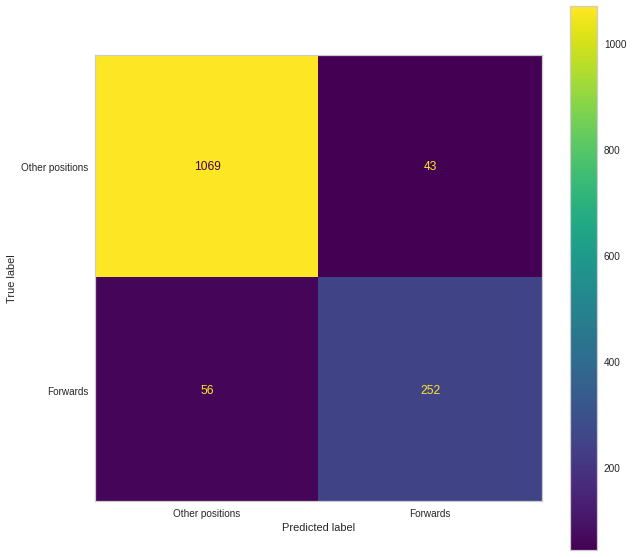

In [48]:
cf_matrix = confusion_matrix(y_train, svm_train_pred)
cmd = ConfusionMatrixDisplay(cf_matrix, display_labels=['Other positions', 'Forwards'])

fig, ax = plt.subplots(figsize=(10,10))
cmd.plot(ax=ax)
plt.grid(False)
plt.show()

In [49]:
train_scores.append(svm_train_pred)

In [50]:
svm_test_pred = gs.predict(X_test_sc)

Wyniki na zbiorze testowym są bardzo zbliżone. Minimalnie słabsze jest klasyfikowanie nie-napastników, stąd też lekki spadek dokładności.

In [51]:
print(classification_report(y_test, svm_test_pred, zero_division=1))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       555
           1       0.83      0.81      0.82       154

    accuracy                           0.92       709
   macro avg       0.89      0.88      0.89       709
weighted avg       0.92      0.92      0.92       709



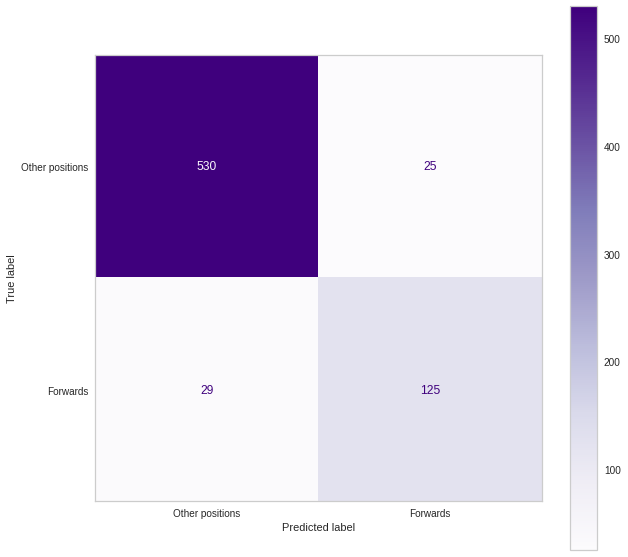

In [52]:
cf_matrix = confusion_matrix(y_test, svm_test_pred)
cmd = ConfusionMatrixDisplay(cf_matrix, display_labels=['Other positions', 'Forwards'])

fig, ax = plt.subplots(figsize=(10,10))
cmd.plot(ax=ax, cmap='Purples')
plt.grid(False)
plt.show()

In [53]:
test_scores.append(svm_test_pred)

####Kernel wielomianowy.

Dla kernela wielomianowego pozostańmy konsekwentni względem kernela liniowego we wskazywaniu wartości parametru C, przetestujmy przy tym takie same, jak w przypadku regresji logistycznej, stopnie wielomianu.

In [54]:
params = {'C': [0.01, 1, 2, 10, 25, 50, 100], 'degree': [1,2,3]}
svc = SVC(probability=True, kernel='poly')

gs = GridSearchCV(svc, param_grid=params, cv=10, verbose=10)
gs.fit(X_train_sc, y_train)
poly_svm_train_pred = gs.predict(X_train_sc)

Fitting 10 folds for each of 21 candidates, totalling 210 fits
[CV 1/10; 1/21] START C=0.01, degree=1..........................................
[CV 1/10; 1/21] END ...........C=0.01, degree=1;, score=0.789 total time=   0.2s
[CV 2/10; 1/21] START C=0.01, degree=1..........................................
[CV 2/10; 1/21] END ...........C=0.01, degree=1;, score=0.796 total time=   0.2s
[CV 3/10; 1/21] START C=0.01, degree=1..........................................
[CV 3/10; 1/21] END ...........C=0.01, degree=1;, score=0.796 total time=   0.2s
[CV 4/10; 1/21] START C=0.01, degree=1..........................................
[CV 4/10; 1/21] END ...........C=0.01, degree=1;, score=0.796 total time=   0.2s
[CV 5/10; 1/21] START C=0.01, degree=1..........................................
[CV 5/10; 1/21] END ...........C=0.01, degree=1;, score=0.810 total time=   0.2s
[CV 6/10; 1/21] START C=0.01, degree=1..........................................
[CV 6/10; 1/21] END ...........C=0.01, degree=

Model zadziałał - jak na dużą liczbę iteracji - bardzo szybko. Co jest charakterystyczne dla maszyn wektorów nośnych, a co nie ujawniło się szczególnie przy kernelu liniowym - współczynnik C jest wysoki. Co ciekawe, w zasadzie nie możemy mówić o wielomianie, gdyż optymalny jest stopień pierwszy. Bardzo bliski poprzednich (nawet minimalnie wyższy) jest najlepszy wskazany wynik.

In [55]:
print(gs.best_params_)
print(gs.best_estimator_)
print(gs.best_score_)

{'C': 25, 'degree': 1}
SVC(C=25, degree=1, kernel='poly', probability=True)
0.926056338028169


Jak można było przewidywać po wskazaniach GridSearcha, wyniki są znów zbliżone. Tak jak w poprzednich modelach, dokładność na zbiorze treningowym wynosi 0,93. Ten model popełnia jeden więcej niż kernel liniowy błąd we wskazaniu napastników.

In [56]:
print(classification_report(y_train, poly_svm_train_pred, zero_division=1))

              precision    recall  f1-score   support

           0       0.95      0.96      0.96      1112
           1       0.85      0.81      0.83       308

    accuracy                           0.93      1420
   macro avg       0.90      0.89      0.89      1420
weighted avg       0.93      0.93      0.93      1420



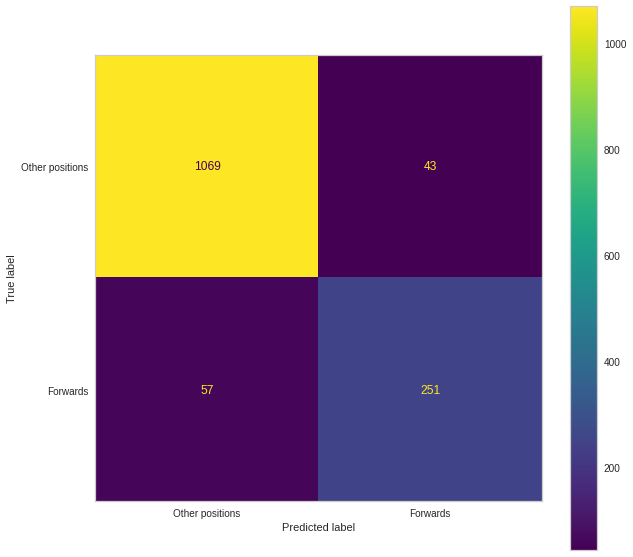

In [57]:
cf_matrix = confusion_matrix(y_train, poly_svm_train_pred)
cmd = ConfusionMatrixDisplay(cf_matrix, display_labels=['Other positions', 'Forwards'])

fig, ax = plt.subplots(figsize=(10,10))
cmd.plot(ax=ax)
plt.grid(False)
plt.show()

In [58]:
train_scores.append(poly_svm_train_pred)

In [59]:
poly_svm_test_pred = gs.predict(X_test_sc)

Przy dwukrotnie mniejszym zbiorze testowym błędy - szczególnie w zakresie wskazania nie-napastników - występują stosunkowo częściej. Tym niemniej również ten model należy uznać za stosunkowo udany.

In [60]:
print(classification_report(y_test, poly_svm_test_pred, zero_division=1))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       555
           1       0.83      0.81      0.82       154

    accuracy                           0.92       709
   macro avg       0.89      0.88      0.88       709
weighted avg       0.92      0.92      0.92       709



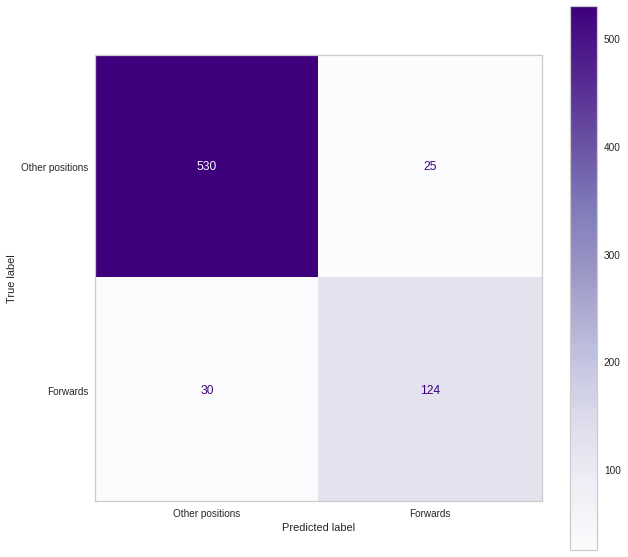

In [61]:
cf_matrix = confusion_matrix(y_test, poly_svm_test_pred)
cmd = ConfusionMatrixDisplay(cf_matrix, display_labels=['Other positions', 'Forwards'])

fig, ax = plt.subplots(figsize=(10,10))
cmd.plot(ax=ax, cmap='Purples')
plt.grid(False)
plt.show()

In [62]:
test_scores.append(poly_svm_test_pred)

###Metoda k-najbliższych sąsiadów.

Dla metody k-najbliższych sąsiadów dobieram nowy zestaw parametrów: n_neighbors, określający liczbę "sąsiadów" wykorzystanych do "głosowania" nad przypisaniem rekordu, oraz weights, wskazujący wagi sąsiednich punktów - czy jest jednolita, czy zależna od odległości (im bliższy punkt, tym wyższa waga).

In [63]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
params = {'n_neighbors': [5, 11, 15, 25], 'weights': ['uniform', 'distance']}
gs = GridSearchCV(knn, param_grid=params, cv=10, verbose=10)
gs.fit(X_train_sc, y_train)
knn_train_pred = gs.predict(X_train_sc)

Fitting 10 folds for each of 8 candidates, totalling 80 fits
[CV 1/10; 1/8] START n_neighbors=5, weights=uniform.............................
[CV 1/10; 1/8] END n_neighbors=5, weights=uniform;, score=0.873 total time=   0.0s
[CV 2/10; 1/8] START n_neighbors=5, weights=uniform.............................
[CV 2/10; 1/8] END n_neighbors=5, weights=uniform;, score=0.894 total time=   0.0s
[CV 3/10; 1/8] START n_neighbors=5, weights=uniform.............................
[CV 3/10; 1/8] END n_neighbors=5, weights=uniform;, score=0.915 total time=   0.0s
[CV 4/10; 1/8] START n_neighbors=5, weights=uniform.............................
[CV 4/10; 1/8] END n_neighbors=5, weights=uniform;, score=0.894 total time=   0.0s
[CV 5/10; 1/8] START n_neighbors=5, weights=uniform.............................
[CV 5/10; 1/8] END n_neighbors=5, weights=uniform;, score=0.887 total time=   0.0s
[CV 6/10; 1/8] START n_neighbors=5, weights=uniform.............................
[CV 6/10; 1/8] END n_neighbors=5, weig

Model zadziałał bardzo szybko i wyliczył, że najlepiej sprawuje się przy 11 sąsiednich punktach i jednolitych wagach tychże. Problemem jednak jest niższy najlepszy wynik: spadł on na poziom 0.896.

In [64]:
print(gs.best_params_)
print(gs.best_estimator_)
print(gs.best_score_)

{'n_neighbors': 11, 'weights': 'uniform'}
KNeighborsClassifier(n_neighbors=11)
0.895774647887324


Model niestety charakteryzuje się najsłabszą dokładnością w wykrywaniu napastników - stosunek wartości TP do FN to 230:78 w zbiorze treningowym i 104:50 w zbiorze testowym. Wprawdzie ponownie dobrze wykrywa on wartości TN (na zbiorze treningowym nawet najlepiej z dotychczasowych), jednakże dla wszystkich dotychczasowych modeli nie było to większym wyzwaniem.

In [65]:
print(classification_report(y_train, knn_train_pred, zero_division=1))

              precision    recall  f1-score   support

           0       0.93      0.96      0.95      1112
           1       0.85      0.75      0.79       308

    accuracy                           0.92      1420
   macro avg       0.89      0.85      0.87      1420
weighted avg       0.91      0.92      0.91      1420



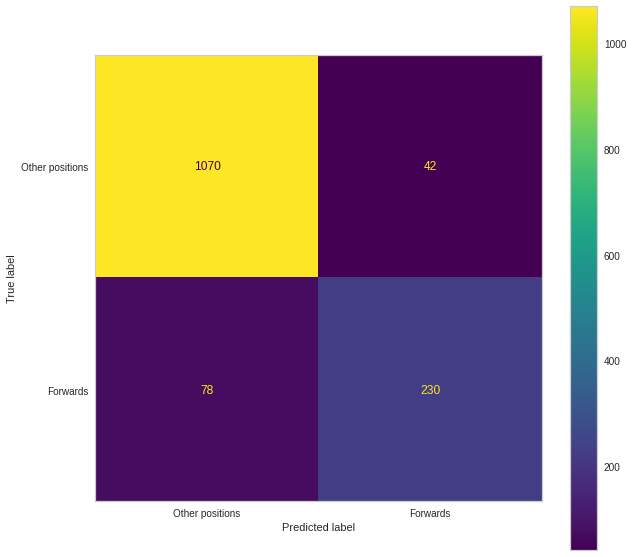

In [66]:
cf_matrix = confusion_matrix(y_train, knn_train_pred)
cmd = ConfusionMatrixDisplay(cf_matrix, display_labels=['Other positions', 'Forwards'])

fig, ax = plt.subplots(figsize=(10,10))
cmd.plot(ax=ax)
plt.grid(False)
plt.show()

In [67]:
train_scores.append(knn_train_pred)

In [68]:
knn_test_pred = gs.predict(X_test_sc)

Nadto problemem jest znaczny overfitting - oprócz słabej klasyfikacji napastników, mamy do czynienia z wyraźnym spadkiem dokładności.

In [69]:
print(classification_report(y_test, knn_test_pred, zero_division=1))

              precision    recall  f1-score   support

           0       0.91      0.95      0.93       555
           1       0.81      0.68      0.73       154

    accuracy                           0.89       709
   macro avg       0.86      0.82      0.83       709
weighted avg       0.89      0.89      0.89       709



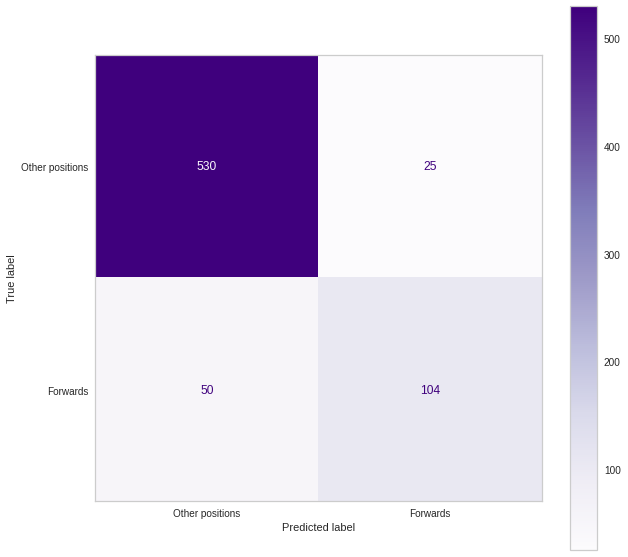

In [70]:
cf_matrix = confusion_matrix(y_test, knn_test_pred)
cmd = ConfusionMatrixDisplay(cf_matrix, display_labels=['Other positions', 'Forwards'])

fig, ax = plt.subplots(figsize=(10,10))
cmd.plot(ax=ax, cmap='Purples')
plt.grid(False)
plt.show()

In [71]:
test_scores.append(knn_test_pred)

###Naiwny klasyfikator Bayesa (NB).

####Gaussowski NB.

Dla modelu gaussowskiego, opartego na twierdzeniu Bayesa, dobieramy hiperparametr var_smoothing - wygładzanie wykładnicze.

In [72]:
from sklearn.naive_bayes import GaussianNB

params = {'var_smoothing': np.linspace(0, 1, num=100)}
gnb = GaussianNB()
gs = GridSearchCV(gnb, param_grid=params, cv=10, verbose=10)
gs.fit(X_train_sc, y_train)
gnb_train_pred = gs.predict(X_train_sc)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
[CV 1/10; 1/100] START var_smoothing=0.0........................................
[CV 1/10; 1/100] END .........var_smoothing=0.0;, score=0.866 total time=   0.0s
[CV 2/10; 1/100] START var_smoothing=0.0........................................
[CV 2/10; 1/100] END .........var_smoothing=0.0;, score=0.838 total time=   0.0s
[CV 3/10; 1/100] START var_smoothing=0.0........................................
[CV 3/10; 1/100] END .........var_smoothing=0.0;, score=0.845 total time=   0.0s
[CV 4/10; 1/100] START var_smoothing=0.0........................................
[CV 4/10; 1/100] END .........var_smoothing=0.0;, score=0.894 total time=   0.0s
[CV 5/10; 1/100] START var_smoothing=0.0........................................
[CV 5/10; 1/100] END .........var_smoothing=0.0;, score=0.803 total time=   0.0s
[CV 6/10; 1/100] START var_smoothing=0.0........................................
[CV 6/10; 1/100] END .........var_smoothing=

Model działa bardzo szybko nawet przy wysokiej liczbie parametrów. GridSearchCV ustalił wysokość parametru wygładzania na poziomie ok. 0,02. Odnotować należy jednak spadek najlepszego wyniku na poziom 0,85.

In [73]:
print(gs.best_params_)
print(gs.best_estimator_)
print(gs.best_score_)

{'var_smoothing': 0.020202020202020204}
GaussianNB(var_smoothing=0.020202020202020204)
0.85


Niestety, model jest szalenie niedokładny. O ile nie-napastnikami radzi sobie całkiem przyzwoicie (chociaż 74 błędne wskazania to zdecydowanie największa liczba jak dotąd), o tyle w stosunku do napastników notuje ponad 40% błędnych wskazań!

In [74]:
print(classification_report(y_train, gnb_train_pred, zero_division=1))

              precision    recall  f1-score   support

           0       0.88      0.93      0.91      1112
           1       0.70      0.56      0.62       308

    accuracy                           0.85      1420
   macro avg       0.79      0.74      0.76      1420
weighted avg       0.84      0.85      0.84      1420



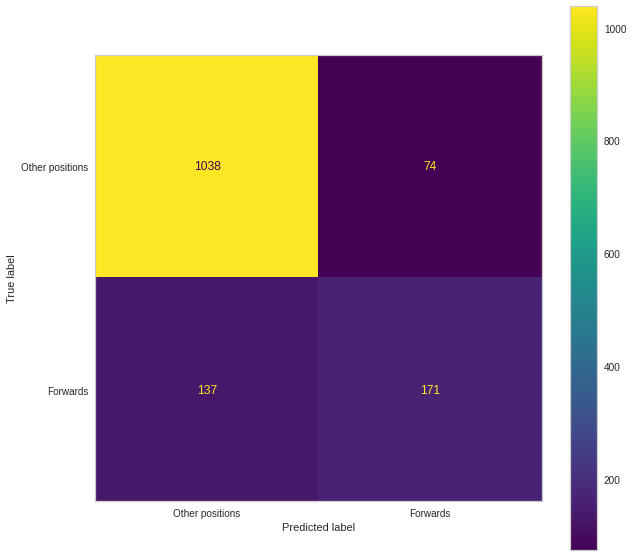

In [75]:
cf_matrix = confusion_matrix(y_train, gnb_train_pred)
cmd = ConfusionMatrixDisplay(cf_matrix, display_labels=['Other positions', 'Forwards'])

fig, ax = plt.subplots(figsize=(10,10))
cmd.plot(ax=ax)
plt.grid(False)
plt.show()

In [76]:
train_scores.append(gnb_train_pred)

In [77]:
gnb_test_pred = gs.predict(X_test_sc)

Nieco lepiej sytuacja przedstawia się na zbiorze testowym - można by rzec, że jest to chyba jedyny jak dotąd model, którego wyniki uległy drobnej poprawie. Nie zmienia to faktu, że jest najgorzej działający z dotychczas przedstawionych modeli.

In [78]:
print(classification_report(y_test, gnb_test_pred, zero_division=1))

              precision    recall  f1-score   support

           0       0.89      0.93      0.91       555
           1       0.69      0.58      0.63       154

    accuracy                           0.85       709
   macro avg       0.79      0.76      0.77       709
weighted avg       0.85      0.85      0.85       709



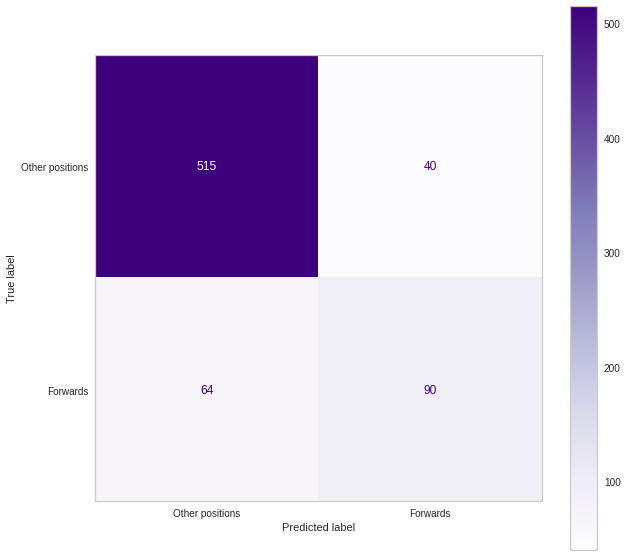

In [79]:
cf_matrix = confusion_matrix(y_test, gnb_test_pred)
cmd = ConfusionMatrixDisplay(cf_matrix, display_labels=['Other positions', 'Forwards'])

fig, ax = plt.subplots(figsize=(10,10))
cmd.plot(ax=ax, cmap='Purples')
plt.grid(False)
plt.show()

In [80]:
test_scores.append(gnb_test_pred)

####Wielomianowy NB.

Naive-Bayesowi wielomianowemu wskażemy jako hiperparametr współczynnik wygładzania addytywnego (Laplace'a/Lidstone'a), ukryty pod nazwą parametru alpha. Podobnie jak w przypadku wygładzania wykładniczego w gaussowskim NB, podamy mu do przetestowania jako wartość 100 liczb z zakresu od 0 do 1. Wielomianowy NB wykorzystuje dane niestandaryzowane.

In [81]:
from sklearn.naive_bayes import MultinomialNB

params = {'alpha': np.linspace(0, 1, num=100)}
mnb = MultinomialNB()
gs = GridSearchCV(mnb, param_grid=params, cv=10, verbose=10)
gs.fit(X_train, y_train)
mnb_train_pred = gs.predict(X_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
[CV 1/10; 1/100] START alpha=0.0................................................
[CV 1/10; 1/100] END .................alpha=0.0;, score=0.789 total time=   0.0s
[CV 2/10; 1/100] START alpha=0.0................................................
[CV 2/10; 1/100] END .................alpha=0.0;, score=0.852 total time=   0.0s
[CV 3/10; 1/100] START alpha=0.0................................................
[CV 3/10; 1/100] END .................alpha=0.0;, score=0.831 total time=   0.0s
[CV 4/10; 1/100] START alpha=0.0................................................
[CV 4/10; 1/100] END .................alpha=0.0;, score=0.831 total time=   0.0s
[CV 5/10; 1/100] START alpha=0.0................................................
[CV 5/10; 1/100] END .................alpha=0.0;, score=0.824 total time=   0.0s
[CV 6/10; 1/100] START alpha=0.0................................................
[CV 6/10; 1/100] END .................alpha=

/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:557: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  % _ALPHA_MIN
/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:557: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  % _ALPHA_MIN
/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:557: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  % _ALPHA_MIN
/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:557: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  % _ALPHA_MIN
/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:557: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  % _ALPHA_MIN
/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:557: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  % _ALPHA_MIN
/usr

[CV 3/10; 3/100] END alpha=0.020202020202020204;, score=0.831 total time=   0.0s
[CV 4/10; 3/100] START alpha=0.020202020202020204...............................
[CV 4/10; 3/100] END alpha=0.020202020202020204;, score=0.831 total time=   0.0s
[CV 5/10; 3/100] START alpha=0.020202020202020204...............................
[CV 5/10; 3/100] END alpha=0.020202020202020204;, score=0.824 total time=   0.0s
[CV 6/10; 3/100] START alpha=0.020202020202020204...............................
[CV 6/10; 3/100] END alpha=0.020202020202020204;, score=0.901 total time=   0.0s
[CV 7/10; 3/100] START alpha=0.020202020202020204...............................
[CV 7/10; 3/100] END alpha=0.020202020202020204;, score=0.866 total time=   0.0s
[CV 8/10; 3/100] START alpha=0.020202020202020204...............................
[CV 8/10; 3/100] END alpha=0.020202020202020204;, score=0.761 total time=   0.0s
[CV 9/10; 3/100] START alpha=0.020202020202020204...............................
[CV 9/10; 3/100] END alpha=0

/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:557: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  % _ALPHA_MIN


Co interesujące, z tak dużego zakresu GridSearchCV wybrał jako najbardziej optymalny alpha 0.0. Najlepszy wynik jest jednak jeszcze niższy niż w poprzednich wypadkach.

In [82]:
print(gs.best_params_)
print(gs.best_estimator_)
print(gs.best_score_)

{'alpha': 0.0}
MultinomialNB(alpha=0.0)
0.834507042253521


Ten model jest pierwszym jak dotąd tak skutecznym w klasyfikowaniu napastników (stosunek 299:9 przewidywań poprawnych do niepoprawnych), a zarazem tak fatalnie się sprawdzającym przy wychwytywaniu nie-napastników - w ich przypadku model myli się 5 razy częściej niż większość dotychczasowych modeli i ponad 3 razy częściej niż najsłabszy!

In [83]:
print(classification_report(y_train, mnb_train_pred, zero_division=1))

              precision    recall  f1-score   support

           0       0.99      0.80      0.88      1112
           1       0.57      0.97      0.72       308

    accuracy                           0.84      1420
   macro avg       0.78      0.88      0.80      1420
weighted avg       0.90      0.84      0.85      1420



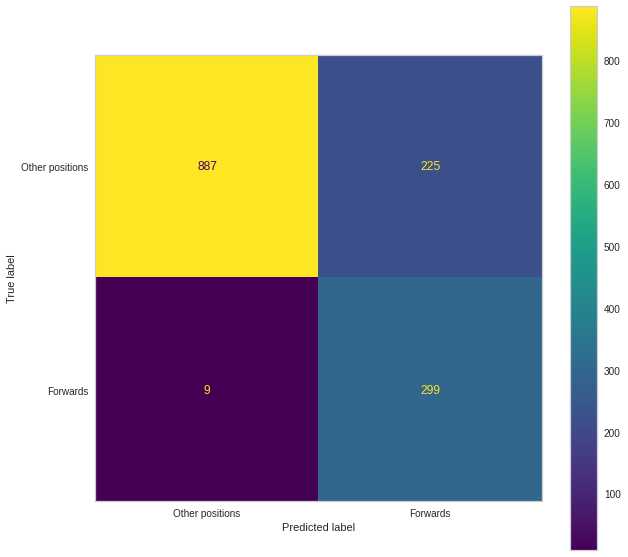

In [84]:
cf_matrix = confusion_matrix(y_train, mnb_train_pred)
cmd = ConfusionMatrixDisplay(cf_matrix, display_labels=['Other positions', 'Forwards'])

fig, ax = plt.subplots(figsize=(10,10))
cmd.plot(ax=ax)
plt.grid(False)
plt.show()

In [85]:
train_scores.append(mnb_train_pred)

In [86]:
mnb_test_pred = gs.predict(X_test)

Model nie tylko słabo dostosował się do danych, ale również jego wyniki spadły w praktycznie każdej metryce.

In [87]:
print(classification_report(y_test, mnb_test_pred, zero_division=1))

              precision    recall  f1-score   support

           0       0.99      0.77      0.87       555
           1       0.54      0.96      0.69       154

    accuracy                           0.82       709
   macro avg       0.76      0.87      0.78       709
weighted avg       0.89      0.82      0.83       709



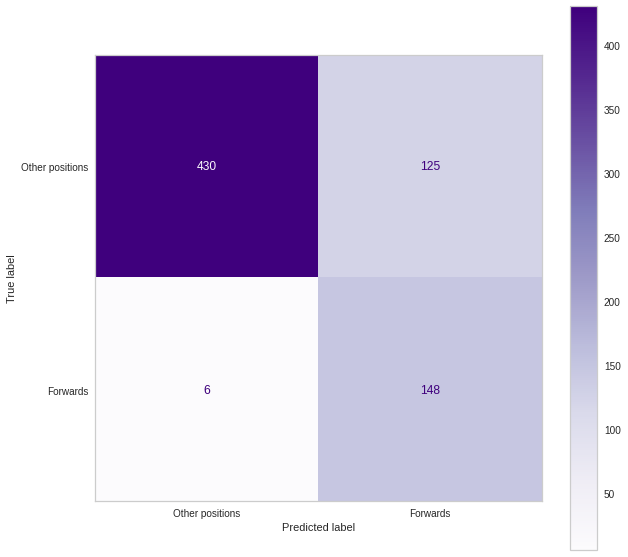

In [88]:
cf_matrix = confusion_matrix(y_test, mnb_test_pred)
cmd = ConfusionMatrixDisplay(cf_matrix, display_labels=['Other positions', 'Forwards'])

fig, ax = plt.subplots(figsize=(10,10))
cmd.plot(ax=ax, cmap='Purples')
plt.grid(False)
plt.show()

In [89]:
test_scores.append(mnb_test_pred)

###Klasyfikator drzewa decyzyjnego.

Drzewu decyzyjnemu dobieramy jako hiperparametry: maksymalną głębokość, minimalną liczbę obserwacji w liściu potrzebną do podziału (min_samples_split) i minimalną wielkość liścia po podziale (min_samples_leaf). Również w tym wypadku nie korzystamy z ustandaryzowanych danych.

In [90]:
from sklearn.tree import DecisionTreeClassifier

params = {'max_depth': [3,4,5], 'min_samples_split': [2,4,6], 'min_samples_leaf': [2,3,4,5]}
dtc = DecisionTreeClassifier()
gs = GridSearchCV(dtc, param_grid=params, cv=10, verbose=10)
gs.fit(X_train, y_train)
dtc_train_pred = gs.predict(X_train)

Fitting 10 folds for each of 36 candidates, totalling 360 fits
[CV 1/10; 1/36] START max_depth=3, min_samples_leaf=2, min_samples_split=2......
[CV 1/10; 1/36] END max_depth=3, min_samples_leaf=2, min_samples_split=2;, score=0.880 total time=   0.0s
[CV 2/10; 1/36] START max_depth=3, min_samples_leaf=2, min_samples_split=2......
[CV 2/10; 1/36] END max_depth=3, min_samples_leaf=2, min_samples_split=2;, score=0.887 total time=   0.0s
[CV 3/10; 1/36] START max_depth=3, min_samples_leaf=2, min_samples_split=2......
[CV 3/10; 1/36] END max_depth=3, min_samples_leaf=2, min_samples_split=2;, score=0.908 total time=   0.0s
[CV 4/10; 1/36] START max_depth=3, min_samples_leaf=2, min_samples_split=2......
[CV 4/10; 1/36] END max_depth=3, min_samples_leaf=2, min_samples_split=2;, score=0.894 total time=   0.0s
[CV 5/10; 1/36] START max_depth=3, min_samples_leaf=2, min_samples_split=2......
[CV 5/10; 1/36] END max_depth=3, min_samples_leaf=2, min_samples_split=2;, score=0.901 total time=   0.0s
[C

Optymalna maksymalna głębokość drzewka wynosi pięć, tak samo jak liczba obserwacji na liść, wielkość liścia natomiast GridSearch wyliczył na dwa. Wzrósł - w stosunkowo do modeli opartych na naiwnym Bayesie - estymowany wynik i wynosi on nieco ponad 0,9.

In [91]:
print(gs.best_params_)
print(gs.best_estimator_)
print(gs.best_score_)

{'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 2}
DecisionTreeClassifier(max_depth=5, min_samples_leaf=5)
0.9007042253521128


Skuteczność przewidywań drzewka jest wysoka, metryki na zbiorze treningowym z reguły przekraczają 0,9. Bardzo dobrze wygląda trafność przewidywań nie-napastników - raptem 34 błędy, powyżej przeciętnej jest również klasyfikowanie napastników.



In [92]:
print(classification_report(y_train, dtc_train_pred, zero_division=1))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1112
           1       0.88      0.83      0.86       308

    accuracy                           0.94      1420
   macro avg       0.92      0.90      0.91      1420
weighted avg       0.94      0.94      0.94      1420



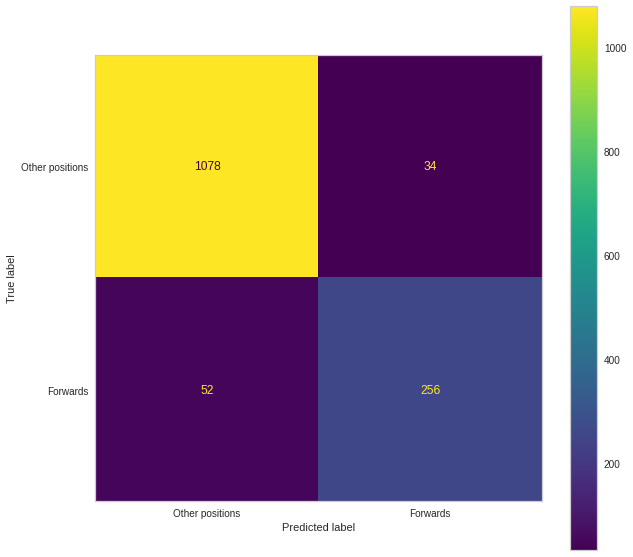

In [93]:
cf_matrix = confusion_matrix(y_train, dtc_train_pred)
cmd = ConfusionMatrixDisplay(cf_matrix, display_labels=['Other positions', 'Forwards'])

fig, ax = plt.subplots(figsize=(10,10))
cmd.plot(ax=ax)
plt.grid(False)
plt.show()

In [94]:
train_scores.append(dtc_train_pred)

In [95]:
dtc_test_pred = gs.predict(X_test)

Niestety, wyniki dla zbioru testowego wskazują na znaczny overfitting. Metryki wyraźnie spadły. Mimo dwukrotnie mniejszego zbioru testowego stosunek błędów w zbiorze testowym do błędów w treningowym wynosi: w stosunku do napastników - 2/3 (33:52), a w stosunku do pozostałych pozycji - niemal 9/10 (30:34).

In [96]:
print(classification_report(y_test, dtc_test_pred, zero_division=1))

              precision    recall  f1-score   support

           0       0.94      0.95      0.94       555
           1       0.80      0.79      0.79       154

    accuracy                           0.91       709
   macro avg       0.87      0.87      0.87       709
weighted avg       0.91      0.91      0.91       709



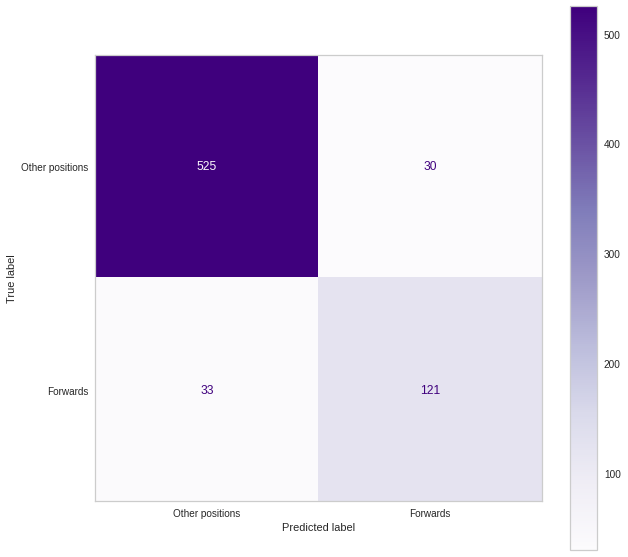

In [97]:
cf_matrix = confusion_matrix(y_test, dtc_test_pred)
cmd = ConfusionMatrixDisplay(cf_matrix, display_labels=['Other positions', 'Forwards'])

fig, ax = plt.subplots(figsize=(10,10))
cmd.plot(ax=ax, cmap='Purples')
plt.grid(False)
plt.show()

In [98]:
test_scores.append(dtc_test_pred)

###Bagging.

Dla klasyfikatora lasu losowego, oprócz podanych przy drzewie decyzyjnym, dobieramy n_estimators: minimalną liczbę "drzew" w "lesie".

In [99]:
from sklearn.ensemble import RandomForestClassifier

params = {'max_depth': [3,4,5], 'min_samples_split': [2,4,6], 'min_samples_leaf': [2,3,4,5], 'n_estimators': [25,50,100]}
rfc = RandomForestClassifier()
gs = GridSearchCV(rfc, param_grid=params, cv=10, verbose=10)
gs.fit(X_train, y_train)
rfc_train_pred = gs.predict(X_train)

Fitting 10 folds for each of 108 candidates, totalling 1080 fits
[CV 1/10; 1/108] START max_depth=3, min_samples_leaf=2, min_samples_split=2, n_estimators=25
[CV 1/10; 1/108] END max_depth=3, min_samples_leaf=2, min_samples_split=2, n_estimators=25;, score=0.930 total time=   0.1s
[CV 2/10; 1/108] START max_depth=3, min_samples_leaf=2, min_samples_split=2, n_estimators=25
[CV 2/10; 1/108] END max_depth=3, min_samples_leaf=2, min_samples_split=2, n_estimators=25;, score=0.852 total time=   0.1s
[CV 3/10; 1/108] START max_depth=3, min_samples_leaf=2, min_samples_split=2, n_estimators=25
[CV 3/10; 1/108] END max_depth=3, min_samples_leaf=2, min_samples_split=2, n_estimators=25;, score=0.894 total time=   0.1s
[CV 4/10; 1/108] START max_depth=3, min_samples_leaf=2, min_samples_split=2, n_estimators=25
[CV 4/10; 1/108] END max_depth=3, min_samples_leaf=2, min_samples_split=2, n_estimators=25;, score=0.880 total time=   0.1s
[CV 5/10; 1/108] START max_depth=3, min_samples_leaf=2, min_samples

Głębokość drzewek powinna być wg GridSearcha dość duża, bo aż pięć, a na las decyzyjny składa się ich aż 100. Dobrze wygląda zaś estymowany wynik: ponownie osiągnął on pułap ok. 0,92.

In [100]:
print(gs.best_params_)
print(gs.best_estimator_)
print(gs.best_score_)

{'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 100}
RandomForestClassifier(max_depth=5, min_samples_leaf=3)
0.9190140845070424


Model świetnie wychwycił zawodników niewystępujących jako napastnicy - w zbiorze treningowym pomylił się ledwie 20 razy! Niestety, ma on znacznie słabszą skuteczność w odsiewaniu napastników. Przeciętna dokładność w granicach 0,95 wygląda ciekawie, jednak - mając na uwadze przeciętny wynik - zwiastuje pewien overfitting.

In [101]:
print(classification_report(y_train, rfc_train_pred, zero_division=1))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1112
           1       0.93      0.84      0.88       308

    accuracy                           0.95      1420
   macro avg       0.94      0.91      0.92      1420
weighted avg       0.95      0.95      0.95      1420



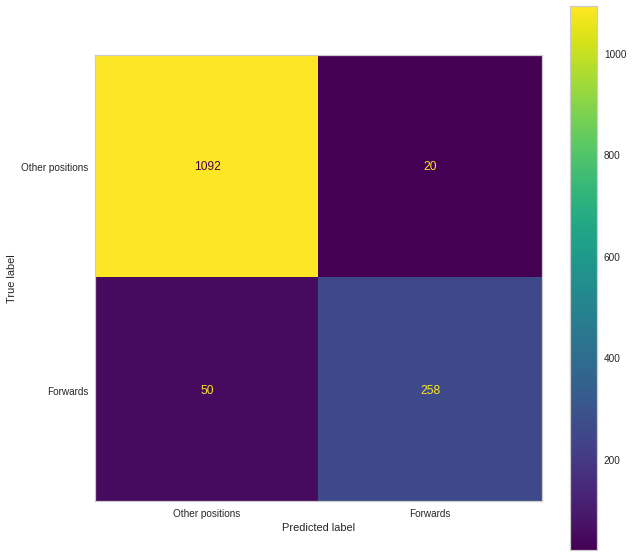

In [102]:
cf_matrix = confusion_matrix(y_train, rfc_train_pred)
cmd = ConfusionMatrixDisplay(cf_matrix, display_labels=['Other positions', 'Forwards'])

fig, ax = plt.subplots(figsize=(10,10))
cmd.plot(ax=ax)
plt.grid(False)
plt.show()

In [103]:
train_scores.append(rfc_train_pred)

In [104]:
rfc_test_pred = gs.predict(X_test)

Niestety, i ten model charakteryzuje się overfittingiem. Wszystkie wyniki spadają, a błędów w przewidywaniu nie-napastników jest nawet o 2 więcej niż w zbiorze uczącym. Mimo względnie wysokiego wyniku, jest to dlań dyskwalifikujące.

In [105]:
print(classification_report(y_test, rfc_test_pred, zero_division=1))

              precision    recall  f1-score   support

           0       0.93      0.96      0.95       555
           1       0.84      0.74      0.79       154

    accuracy                           0.91       709
   macro avg       0.88      0.85      0.87       709
weighted avg       0.91      0.91      0.91       709



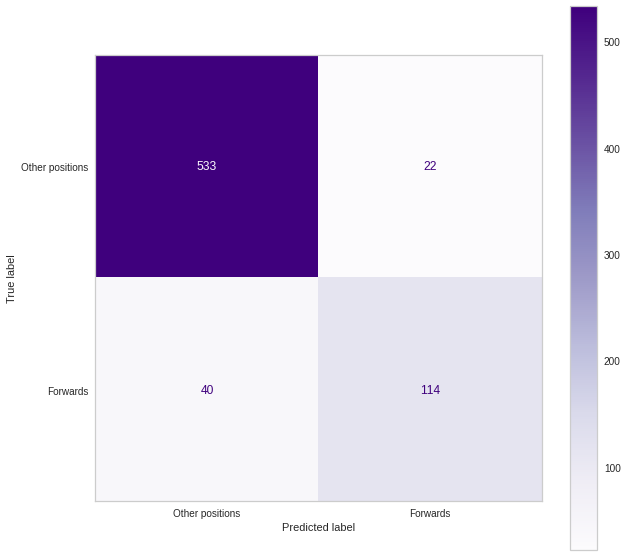

In [106]:
cf_matrix = confusion_matrix(y_test, rfc_test_pred)
cmd = ConfusionMatrixDisplay(cf_matrix, display_labels=['Other positions', 'Forwards'])

fig, ax = plt.subplots(figsize=(10,10))
cmd.plot(ax=ax, cmap='Purples')
plt.grid(False)
plt.show()

In [107]:
test_scores.append(rfc_test_pred)

###Boosting.

AdaBoostClassifierowi, jako zespołowi klasyfikatorów, wskażę jako parametry liczbę klasyfikatorów w zespole (n_estimators), wagi nadawane klasyfikatorom przy każdej kolejnej iteracji (learning_rate) oraz algorytm boostingu (SAMME - boosting dyskretny, SAMME.R - boosting realny). Tablica zbudowana do iteracji dla drugiego z parametrów będzie nieco mniejsza i składać się będzie z 15 elementów, aby model zadziałał względnie szybko, a minimalna wartość znajdująca się w niej będzie większa od 0 (maksymalna to 1), bo przy zerowej wadze klasyfikatorów GridSearchCV wskazuje wynik NaN. W różnych modelach prezentuje się różne podejścia do wykorzystania zestandaryzowanych danych przy boostingu - ja jednak uważam, że warto wykorzystywać standaryzację, zwłaszcza gdy wcześniej zastosowano redukcję wymiarowości w celu zmniejszenia zbioru cech.

In [109]:
from sklearn.ensemble import AdaBoostClassifier

params = {'n_estimators': [75, 100], 'learning_rate': np.linspace(0.001, 1, num=15), 'algorithm': ['SAMME', 'SAMME.R']}
abc = AdaBoostClassifier()
gs = GridSearchCV(abc, param_grid=params, cv=10, verbose=10)
gs.fit(X_train_sc, y_train)
abc_train_pred = gs.predict(X_train_sc)

Fitting 10 folds for each of 60 candidates, totalling 600 fits
[CV 1/10; 1/60] START algorithm=SAMME, learning_rate=0.001, n_estimators=75.....
[CV 1/10; 1/60] END algorithm=SAMME, learning_rate=0.001, n_estimators=75;, score=0.859 total time=   0.6s
[CV 2/10; 1/60] START algorithm=SAMME, learning_rate=0.001, n_estimators=75.....
[CV 2/10; 1/60] END algorithm=SAMME, learning_rate=0.001, n_estimators=75;, score=0.873 total time=   0.7s
[CV 3/10; 1/60] START algorithm=SAMME, learning_rate=0.001, n_estimators=75.....
[CV 3/10; 1/60] END algorithm=SAMME, learning_rate=0.001, n_estimators=75;, score=0.838 total time=   0.7s
[CV 4/10; 1/60] START algorithm=SAMME, learning_rate=0.001, n_estimators=75.....
[CV 4/10; 1/60] END algorithm=SAMME, learning_rate=0.001, n_estimators=75;, score=0.859 total time=   0.8s
[CV 5/10; 1/60] START algorithm=SAMME, learning_rate=0.001, n_estimators=75.....
[CV 5/10; 1/60] END algorithm=SAMME, learning_rate=0.001, n_estimators=75;, score=0.852 total time=   0.

Algorytm nie należy do przesadnie szybkich, ale daje obiecujące wyniki: 100 klasyfikatorów i ich wagi na poziomie ok. 0.786 oraz algorytm SAMME - to optymalne parametry dobrane przez GridSearcha. Najlepszy średni wynik dla iteracji jest obiecujący i wynosi ok. 0.925.

In [110]:
print(gs.best_params_)
print(gs.best_estimator_)
print(gs.best_score_)

{'algorithm': 'SAMME', 'learning_rate': 0.7859285714285714, 'n_estimators': 100}
AdaBoostClassifier(algorithm='SAMME', learning_rate=0.7859285714285714,
                   n_estimators=100)
0.9246478873239437


Dokładność tego modelu wobec zbioru treningowego jest wysoka - wynosi 0.94. Co ciekawe, jego wyniki stanowią kompromis między wysoką dokładnością klasyfikowania napastników i pozostałych graczy - w przypadku tych pierwszych myli się 44 razy na 308 obserwacji, w przypadku drugich - 35 razy na 1112 obserwacji. Jak dobrze jednak wiadomo, wartość modelu oceni nam jego skuteczność na zbiorze testowym.

In [111]:
print(classification_report(y_train, abc_train_pred, zero_division=1))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96      1112
           1       0.88      0.86      0.87       308

    accuracy                           0.94      1420
   macro avg       0.92      0.91      0.92      1420
weighted avg       0.94      0.94      0.94      1420



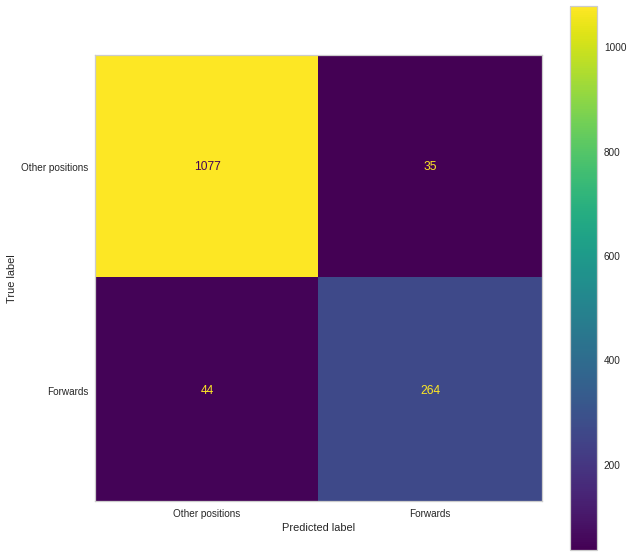

In [112]:
cf_matrix = confusion_matrix(y_train, abc_train_pred)
cmd = ConfusionMatrixDisplay(cf_matrix, display_labels=['Other positions', 'Forwards'])

fig, ax = plt.subplots(figsize=(10,10))
cmd.plot(ax=ax)
plt.grid(False)
plt.show()

In [113]:
train_scores.append(abc_train_pred)

In [114]:
abc_test_pred = gs.predict(X_test_sc)

Niestety, model okazuje się być przeuczony. Dokładność spadła z 0.94 na 0.91, przy czym stosunkowo model myli się wyraźnie częściej. Liczba błędów spadła tylko o kilka wyników w obu klasach.

In [115]:
print(classification_report(y_test, abc_test_pred, zero_division=1))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       555
           1       0.81      0.76      0.78       154

    accuracy                           0.91       709
   macro avg       0.87      0.85      0.86       709
weighted avg       0.91      0.91      0.91       709



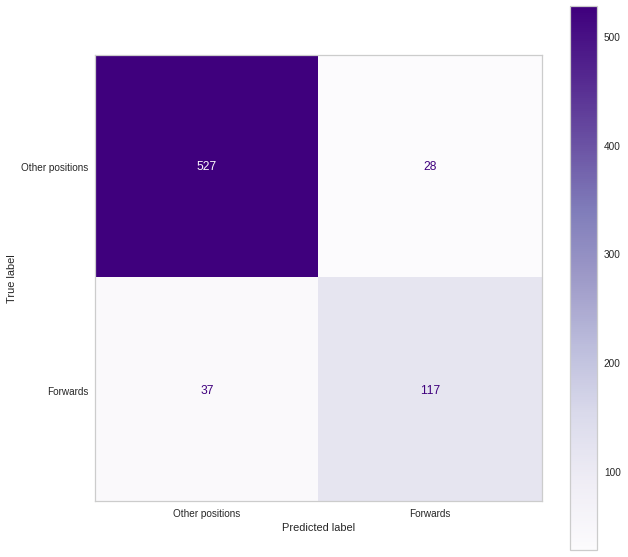

In [116]:
cf_matrix = confusion_matrix(y_test, abc_test_pred)
cmd = ConfusionMatrixDisplay(cf_matrix, display_labels=['Other positions', 'Forwards'])

fig, ax = plt.subplots(figsize=(10,10))
cmd.plot(ax=ax, cmap='Purples')
plt.grid(False)
plt.show()

In [117]:
test_scores.append(abc_test_pred)

###Sieć neuronowa - MLP Classifier.

Scikit-learn posiada własny moduł pozwalający na klasyfikację przy użyciu sztucznych sieci neuronowych. Z uwagi na długi czas iteracji, ograniczmy się do dwóch hiperparametrów:
- hidden_layer_sizes: krotka określająca liczbę warstw ukrytych perceptronu i zawartych w nich neuronów, 
- activation: funkcja aktywacji neuronu wyjścia,
- solver" algorytm optymalizacji.

Sieć będzie w obu przypadkach składać się z tej samej liczby neuronów: 50, rozmieszczonych w różnych konfiguracjach.

In [118]:
from sklearn.neural_network import MLPClassifier

params ={
    'hidden_layer_sizes': [(20,20,10), (10,10,10,10,10)],
    'activation': ['tanh', 'relu', 'identity', 'logistic'],
    'solver': ['adam', 'sgd']
}

mlp = MLPClassifier(max_iter=50000)
gs = GridSearchCV(mlp, param_grid=params, cv=10, verbose=10)
gs.fit(X_train_sc, y_train)
mlp_train_pred = gs.predict(X_train_sc)

Fitting 10 folds for each of 16 candidates, totalling 160 fits
[CV 1/10; 1/16] START activation=tanh, hidden_layer_sizes=(20, 20, 10), solver=adam
[CV 1/10; 1/16] END activation=tanh, hidden_layer_sizes=(20, 20, 10), solver=adam;, score=0.880 total time=   6.3s
[CV 2/10; 1/16] START activation=tanh, hidden_layer_sizes=(20, 20, 10), solver=adam
[CV 2/10; 1/16] END activation=tanh, hidden_layer_sizes=(20, 20, 10), solver=adam;, score=0.908 total time=   3.0s
[CV 3/10; 1/16] START activation=tanh, hidden_layer_sizes=(20, 20, 10), solver=adam
[CV 3/10; 1/16] END activation=tanh, hidden_layer_sizes=(20, 20, 10), solver=adam;, score=0.880 total time=   4.6s
[CV 4/10; 1/16] START activation=tanh, hidden_layer_sizes=(20, 20, 10), solver=adam
[CV 4/10; 1/16] END activation=tanh, hidden_layer_sizes=(20, 20, 10), solver=adam;, score=0.908 total time=   5.1s
[CV 5/10; 1/16] START activation=tanh, hidden_layer_sizes=(20, 20, 10), solver=adam
[CV 5/10; 1/16] END activation=tanh, hidden_layer_sizes=(

Model, niestety, nie należy do najszybszych - na niektóre iteracje potrzebuje nawet kilkanaście sekund. GridSearch wskazuje, że optymalną funkcją aktywacji jest funkcja tożsamościowa, optymalizatorem - ADAM (Adaptive Moment Estimation), zaś najlepiej działa sieć składająca się z 5 warstw ukrytych z 10 neuronami każda. Wynik ok. 0,925 wygląda przyzwoicie, jednak przy takim koszcie obliczeń nie jest on zbyt zadowalający.

In [119]:
print(gs.best_params_)
print(gs.best_estimator_)
print(gs.best_score_)

{'activation': 'identity', 'hidden_layer_sizes': (10, 10, 10, 10, 10), 'solver': 'adam'}
MLPClassifier(activation='identity', hidden_layer_sizes=(10, 10, 10, 10, 10),
              max_iter=50000)
0.9253521126760564


Sieć notuje przyzwoite wyniki na zbiorze treningowym. Dokładność wyniosła 0,93. Tradycyjnie już model dobrze wykrywa zawodników z innych pozycji niż napastnicy (1061/1112 dokładności) i słabiej napastników (258/308).

In [120]:
print(classification_report(y_train, mlp_train_pred, zero_division=1))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1112
           1       0.83      0.84      0.84       308

    accuracy                           0.93      1420
   macro avg       0.89      0.90      0.90      1420
weighted avg       0.93      0.93      0.93      1420



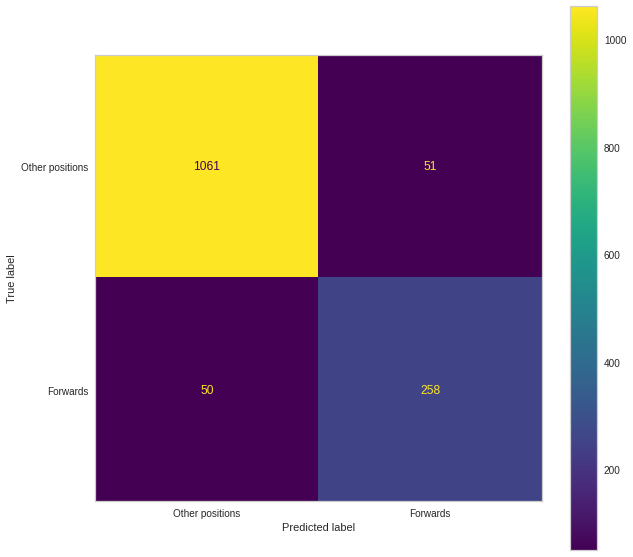

In [121]:
cf_matrix = confusion_matrix(y_train, mlp_train_pred)
cmd = ConfusionMatrixDisplay(cf_matrix, display_labels=['Other positions', 'Forwards'])

fig, ax = plt.subplots(figsize=(10,10))
cmd.plot(ax=ax)
plt.grid(False)
plt.show()

In [122]:
train_scores.append(mlp_train_pred)

In [123]:
mlp_test_pred = gs.predict(X_test_sc)

Niestety, wyniki na zbiorze testowym są minimalnie gorsze. Spada dokładność przewidywania w przypadku obu kategorii.

In [124]:
print(classification_report(y_test, mlp_test_pred, zero_division=1))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       555
           1       0.81      0.81      0.81       154

    accuracy                           0.92       709
   macro avg       0.88      0.88      0.88       709
weighted avg       0.92      0.92      0.92       709



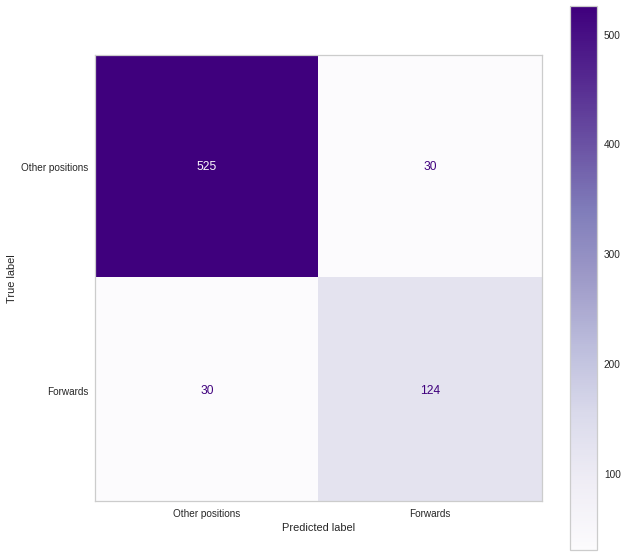

In [125]:
cf_matrix = confusion_matrix(y_test, mlp_test_pred)
cmd = ConfusionMatrixDisplay(cf_matrix, display_labels=['Other positions', 'Forwards'])

fig, ax = plt.subplots(figsize=(10,10))
cmd.plot(ax=ax, cmap='Purples')
plt.grid(False)
plt.show()

In [126]:
test_scores.append(mlp_test_pred)

##Podsumowanie.

Zbiór danych, który wykorzystałem w tej części projektu, nie należy do najłatwiejszych w budowaniu na jego podstawie modelu. Modele z reguły bardzo dobrze radziły sobie w klasyfikowaniu zawodników niegrających jako napastnicy i z reguły dokładność w przewidywaniu tychże przekracza 0,95. Gorzej jest z klasyfikowaniem napastników - najlepsze modele mają w tym zakresie dokładność w granicach 0,8. Bardzo dobrą skuteczność w tym zakresie notował wielomianowy Naive-Bayes, jednakowoż bardzo źle spisywał się on w klasyfikowaniu większej grupy.

Problemem w klasyfikacji napastników może być natomiast fakt, iż część z nich odnotowuje słabe statystyki - zdobywają mało goli, zaliczają niewiele asyst, rzadziej próbują dryblować. Da się to uzasadnić ich słabszymi umiejętnościami, grą w słabych zespołach, które nie tworzą im dogodnych sytuacji na stworzenie zagrożenia, względnie rolą na boisku - często nominalni napastnicy pełnią w istocie funkcję zawodnika, którego zadaniem jest absorbować na sobie obrońców, odgrywać piłkę do lepiej ustawionych partnerów. Są też sytuacje przeciwne - nominalni pomocnicy, a rzadziej obrońcy, notują tak dobre statystyki w ofensywie, że modele klasyfikują ich jako napastników. Są to jednak wyjątki od ogólnej reguły, co znajduje potwierdzenie w wynikach uwidocznionych przez macierze pomyłek.

Wracając do samego modelu - porównajmy sobie wyniki dokładności poszczególnych modeli i sprawdźmy raz jeszcze, które są najdokładniejsze, które gwarantują najmniejszy spadek skuteczności w zbiorze testowym itp.

Wykorzystujemy w tym zbudowane wcześniej listy, które wcześniej konsekwentnie budowaliśmy, i na ich podstawie stwórzmy słowniki, które jako wartości przyjmą metryki dokładności i F1-score zaś jako klucze - wskazanie, których zbiorów dotyczą.

In [127]:
scores = {'Training accuracy': [accuracy_score(y_train, i) for i in train_scores],
          'Test accuracy': [accuracy_score(y_test, i) for i in test_scores],
          'Training F1 score': [f1_score(y_train, i) for i in train_scores],
          'Test F1 score': [f1_score(y_test, i) for i in test_scores]}

Taka konstrukcja słowników pozwoli nam łatwo przekształcić je w kolumny ramki danych. Jako indeksy wskażemy nazwy poszczególnych klasyfikatorów, do których wyniki się odnoszą.

In [128]:
scores = pd.DataFrame(scores, index=['Logistic Regression', 'SVM', 'Polynomial SVM',
                                     'K-nearest neighbors', 'Gaussian NB', 
                                     'Multinomial NB', 'Decision tree',
                                     'Bagging', 'Boosting', 'MLP'])
scores

,Training accuracy,Test accuracy,Training F1 score,Test F1 score
Logistic Regression,0.928873,0.916784,0.831386,0.806557
SVM,0.930282,0.923836,0.835821,0.822368
Polynomial SVM,0.929577,0.922426,0.833887,0.818482
K-nearest neighbors,0.915493,0.894217,0.793103,0.734982
Gaussian NB,0.851408,0.853315,0.618445,0.633803
Multinomial NB,0.835211,0.815233,0.718750,0.693208
Decision tree,0.939437,0.911142,0.856187,0.793443
Bagging,0.950704,0.912553,0.880546,0.786207
Boosting,0.944366,0.908322,0.869852,0.782609
MLP,0.928873,0.915374,0.836305,0.805195


Stwórzmy kolumny, która uwidocznią nam różnice między wynikami ze zbioru treningowego i testowego.

In [129]:
scores['Accuracy difference'] = scores['Training accuracy'] - scores['Test accuracy']
scores['F1 difference'] = scores['Training F1 score'] - scores['Test F1 score']
scores

,Training accuracy,Test accuracy,Training F1 score,Test F1 score,Accuracy difference,F1 difference
Logistic Regression,0.928873,0.916784,0.831386,0.806557,0.012089,0.024828
SVM,0.930282,0.923836,0.835821,0.822368,0.006445,0.013452
Polynomial SVM,0.929577,0.922426,0.833887,0.818482,0.007152,0.015405
K-nearest neighbors,0.915493,0.894217,0.793103,0.734982,0.021276,0.058121
Gaussian NB,0.851408,0.853315,0.618445,0.633803,-0.001906,-0.015358
Multinomial NB,0.835211,0.815233,0.718750,0.693208,0.019979,0.025542
Decision tree,0.939437,0.911142,0.856187,0.793443,0.028294,0.062745
Bagging,0.950704,0.912553,0.880546,0.786207,0.038151,0.094339
Boosting,0.944366,0.908322,0.869852,0.782609,0.036045,0.087243
MLP,0.928873,0.915374,0.836305,0.805195,0.013499,0.031110


Wnioski:
- najlepiej z klasyfikacją poradziły sobie Support Vectors Machines; kernele liniowy i wielomianowy notują bardzo zbliżone wyniki na obu zbiorach, w tym najwyższe na zbiorze testowym, ponadto są szybkie obliczeniowo. Zbliżone wyniki notują: regresja logistyczna, która jednak działa powoli w przypadku dopasowania stopnia wielomianu wyższego niż drugi, i sieci neuronowe, które w każdym wypadku działają za wolno,
- zespoły klasyfikatorów (Random Forest i AdaBoost), choć wykazują wysoką skuteczność na zbiorze treningowym, są przeuczone, stosunkowo częściej mylą się w zbiorze testowym niż w uczącym i odnotowują znaczne spadki zarówno, jeśli chodzi o dokładność, jak i F1 score,
- rozczarowująco działa klasyfikator oparty na sztucznych sieciach neuronowych - jego wyniki nie przedstawiają się najgorzej, ale dyskwalifikuje go słaba prędkość działania,
- klasyfikatory oparte na klasyfikatorze naiwnego Bayesa wypadają zdecydowanie najsłabiej, co może w jakiejś części wynikać z różnicy w liczebności klas, jak i z samych założeń, na których opiera się ich działanie,
- klasyfikatory wykorzystujące koncepcje drzew/lasów decyzyjnych, zespoły klasyfikatorów i metoda k-najbliższych sąsiadów mają największy overfitting,
- jedynym klasyfikatorem z lepszym wynikiem w zbiorze testowym jest gaussowski Naive Bayes, jednak problemy z nim nie pozwalają uznać go za dobrej jakości klasyfikator. Przyjmując jako dopuszczalną granicę między dobrym wyuczeniem a przeuczeniem różnicę 0,01 w dokładności i 0,02 w metryce F1 na korzyść zbioru treningowego, widzimy, że z dobrze działających klasyfikatorów w tej kategorii mieszczą się jedynie SVM-y i sieci neuronowe.

#Kategoryzacja wieloklasowa.

Przechodzimy do klasyfikacji wieloklasowej. Tym razem nasze modele będą miały za zadanie przypisać wszystkich zawodników do każdej z pozycji - bramkarz, obrońca, pomocnik, napastnik. Odpuszczę sobie klasyfikatory drzewa decyzyjnego i K-najbliższych sąsiadów (ze względu na niewyróżniające się niczym wyniki), wielomianowego Naive Bayesa (gdyż w zupełności wystarczy sprawdzenie gaussowskiego dla zbadania skuteczności modeli opartych na tym twierdzeniu) i sztuczne sieci neuronowe (gdyż klasyfikacja z ich wykorzystaniem może trwać bardzo długo).

Zaczynamy od wykorzystania LabelEncodera, który przekształci poszczególne kategorie typu string na etykiety numeryczne.

In [130]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_l = le.fit_transform(Y)

In [131]:
le.classes_

array(['Attacker', 'Defender', 'Goalkeeper', 'Midfielder'], dtype=object)

In [132]:
np.unique(y_l)

array([0, 1, 2, 3])

Proporcje zbiorów treningowego i testowego zachowujemy takie, jak w przypadku pierwszej części projektu.

In [133]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y_l,
                                                    test_size = 0.333,
                                                    random_state = 42, stratify=y_l)

Ponownie standaryzujemy zbiory treningowy i testowy, dokonujemy również redukcji wymiarowości z użyciem tej samej liczby cech, co w klasyfikacji binarnej.

In [134]:
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

pca = PCA(n_components=20)
X_train_sc = pca.fit_transform(X_train_sc)
X_test_sc = pca.transform(X_test_sc)

##Regresja logistyczna.

Z uwagi na długość obliczeń (nawet kilkanaście sekund na iterację), ograniczmy liczbę testowanych stopni wielomianu do pierwszego i drugiego. W zamian za to wypróbuję więcej wartości współczynnika kary C, jednak tym razem (z ww. powodów) mniejszych.

In [135]:
pipe = Pipeline([
    ('poly', PolynomialFeatures()),
    ('lr', LogisticRegression(warm_start=True, max_iter=50000))
])

params = {'poly__degree': [1, 2], 'lr__C': [0.01, 0.1, 1, 2, 5, 10]}
gs = GridSearchCV(pipe, param_grid=params, cv=10, verbose=10)
gs.fit(X_train_sc, y_train)
lr_train_pred = gs.predict(X_train_sc)

Fitting 10 folds for each of 12 candidates, totalling 120 fits
[CV 1/10; 1/12] START lr__C=0.01, poly__degree=1................................
[CV 1/10; 1/12] END .lr__C=0.01, poly__degree=1;, score=0.711 total time=   0.0s
[CV 2/10; 1/12] START lr__C=0.01, poly__degree=1................................
[CV 2/10; 1/12] END .lr__C=0.01, poly__degree=1;, score=0.761 total time=   0.0s
[CV 3/10; 1/12] START lr__C=0.01, poly__degree=1................................
[CV 3/10; 1/12] END .lr__C=0.01, poly__degree=1;, score=0.768 total time=   0.0s
[CV 4/10; 1/12] START lr__C=0.01, poly__degree=1................................
[CV 4/10; 1/12] END .lr__C=0.01, poly__degree=1;, score=0.739 total time=   0.0s
[CV 5/10; 1/12] START lr__C=0.01, poly__degree=1................................
[CV 5/10; 1/12] END .lr__C=0.01, poly__degree=1;, score=0.803 total time=   0.0s
[CV 6/10; 1/12] START lr__C=0.01, poly__degree=1................................
[CV 6/10; 1/12] END .lr__C=0.01, poly__degree=

Dobór parametrów trwał dość długo, niektóre iteracje trwały niemal tyle, ile przy klasyfikacji z użyciem sieci neuronowych. Optymalne parametry to: pierwszy stopień wielomianu i współczynnik C równy 5. Estymowany wynik jest znacznie niższego rzędu niż w wypadku poprzedniego modelowania i oscyluje w granicach 0,794.

In [136]:
print(gs.best_params_)
print(gs.best_estimator_)
print(gs.best_score_)

{'lr__C': 5, 'poly__degree': 1}
Pipeline(steps=[('poly', PolynomialFeatures(degree=1)),
                ('lr',
                 LogisticRegression(C=5, max_iter=50000, warm_start=True))])
0.7936619718309859


Model notuje 100% skuteczności przy "odsiewaniu" bramkarzy, jednak wyraźnie gorzej spisuje się wobec pozostałych kategorii. Na uwagę zasługuje słaba skuteczność w stosunku do pomocników - wszystkie metryki przyjmują wartość ok. 0,72.

In [137]:
print(classification_report(le.inverse_transform(y_train), le.inverse_transform(lr_train_pred), zero_division=1))

              precision    recall  f1-score   support

    Attacker       0.86      0.85      0.86       308
    Defender       0.81      0.82      0.81       515
  Goalkeeper       1.00      1.00      1.00       102
  Midfielder       0.73      0.72      0.72       495

    accuracy                           0.80      1420
   macro avg       0.85      0.85      0.85      1420
weighted avg       0.80      0.80      0.80      1420



Z macierzy pomyłek wynika, że żadna z pozycji nie jest mylona z bramkarzami. Model nawet lepiej niż w klasyfikacji binarnej poradził sobie z napastnikami. Duże trudności napotkała klasyfikacja pomocników - myleni są stosunkowo często zarówno z obrońcami (43 razy), jak i z napastnikami (95 razy).

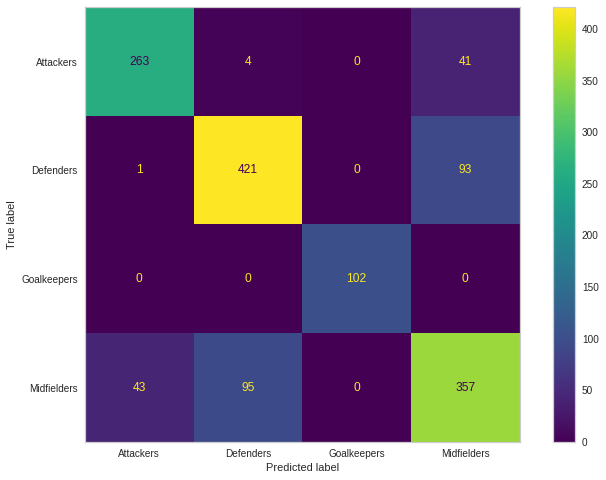

In [138]:
cf_matrix = confusion_matrix(y_train, lr_train_pred)
cmd = ConfusionMatrixDisplay(cf_matrix, display_labels=['Attackers', 'Defenders', 'Goalkeepers', 'Midfielders'])

fig, ax = plt.subplots(figsize=(12,8))
cmd.plot(ax=ax)
plt.grid(False)
plt.show()

In [139]:
lr_test_pred = gs.predict(X_test_sc)

Ewalucja na poziomie zbioru testowego wskazuje jednak na znaczny overfitting. Wyniki spadają - poza bramkarzami - w każdej możliwej rubryce. Bezprecedensowy w warunkach projektu jest spadek dokładności - o 0,05!

In [140]:
print(classification_report(le.inverse_transform(y_test), le.inverse_transform(lr_test_pred), zero_division=1))

              precision    recall  f1-score   support

    Attacker       0.80      0.75      0.77       154
    Defender       0.77      0.79      0.78       257
  Goalkeeper       1.00      1.00      1.00        51
  Midfielder       0.65      0.66      0.65       247

    accuracy                           0.75       709
   macro avg       0.81      0.80      0.80       709
weighted avg       0.75      0.75      0.75       709



Model ponownie nie radzi sobie szczególnie dobrze z pomocnikami: na 247 błędnie wskazał 84.

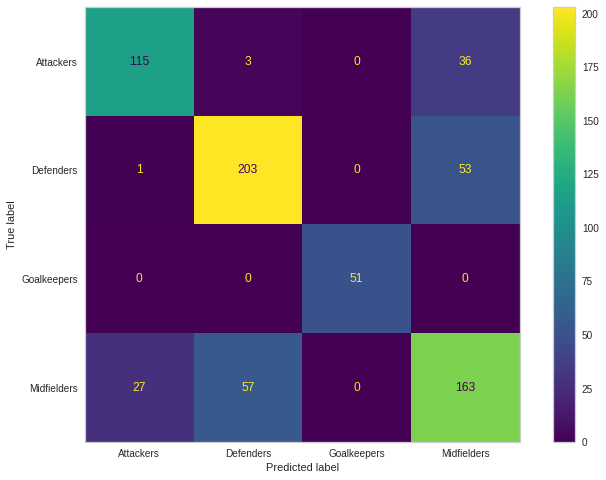

In [141]:
cf_matrix = confusion_matrix(y_test, lr_test_pred)
cmd = ConfusionMatrixDisplay(cf_matrix, display_labels=['Attackers', 'Defenders', 'Goalkeepers', 'Midfielders'])

fig, ax = plt.subplots(figsize=(12,8))
cmd.plot(ax=ax)
plt.grid(False)
plt.show()

Wzorem części z klasyfikacją binarną, tworzymy listy celem dalszego przekształcania.

In [142]:
train_scores = []
train_scores.append(lr_train_pred)

In [143]:
test_scores = []
test_scores.append(lr_test_pred)

##SVM.

###Kernele jednomianowe.

Dla kernela jednomianowego ponownie dobieramy te same wartości parametrów, co przy poprzedniej sposobności.

In [144]:
params = {'C': [0.01, 1, 2, 10, 25, 50, 100], 'kernel': ['linear', 'rbf', 'sigmoid']}
svc = SVC()
gs = GridSearchCV(svc, param_grid=params, cv=10, verbose=10)
gs.fit(X_train_sc, y_train)
svm_train_pred = gs.predict(X_train_sc)

Fitting 10 folds for each of 21 candidates, totalling 210 fits
[CV 1/10; 1/21] START C=0.01, kernel=linear.....................................
[CV 1/10; 1/21] END ......C=0.01, kernel=linear;, score=0.725 total time=   0.1s
[CV 2/10; 1/21] START C=0.01, kernel=linear.....................................
[CV 2/10; 1/21] END ......C=0.01, kernel=linear;, score=0.746 total time=   0.0s
[CV 3/10; 1/21] START C=0.01, kernel=linear.....................................
[CV 3/10; 1/21] END ......C=0.01, kernel=linear;, score=0.761 total time=   0.0s
[CV 4/10; 1/21] START C=0.01, kernel=linear.....................................
[CV 4/10; 1/21] END ......C=0.01, kernel=linear;, score=0.704 total time=   0.1s
[CV 5/10; 1/21] START C=0.01, kernel=linear.....................................
[CV 5/10; 1/21] END ......C=0.01, kernel=linear;, score=0.754 total time=   0.0s
[CV 6/10; 1/21] START C=0.01, kernel=linear.....................................
[CV 6/10; 1/21] END ......C=0.01, kernel=linea

Również tutaj wyniki są przyzwoite - przy przyjęciu kernela liniowego i współczynnika C = 50 estymowany wynik to ok. 0,8. Należy pamiętać, że klasyfikacja wieloklasowa w tym wypadku nie należy do najłatwiejszych - część rekordów na poszczególnych pozycjach jest do siebie dosyć podobna i często nie jest trudno o błąd.

In [145]:
print(gs.best_params_)
print(gs.best_estimator_)
print(gs.best_score_)

{'C': 50, 'kernel': 'linear'}
SVC(C=50, kernel='linear')
0.7992957746478873


100% skuteczności w stosunku do bramkarzy, słabsza wobec obrońców, nieco wyższa w przypadku pozostałych pozycji - ten model jest na zbiorze treningowym skuteczniejszy niż poprzedni.

In [146]:
print(classification_report(le.inverse_transform(y_train), le.inverse_transform(svm_train_pred), zero_division=1))

              precision    recall  f1-score   support

    Attacker       0.87      0.88      0.87       308
    Defender       0.83      0.82      0.82       515
  Goalkeeper       1.00      1.00      1.00       102
  Midfielder       0.74      0.75      0.74       495

    accuracy                           0.82      1420
   macro avg       0.86      0.86      0.86      1420
weighted avg       0.82      0.82      0.82      1420



Wyniki na macierzy pomyłek wskazują na całkiem sporą poprawę (odpowiednio 12 i 9) w przewidywaniu pomocników i napastników.

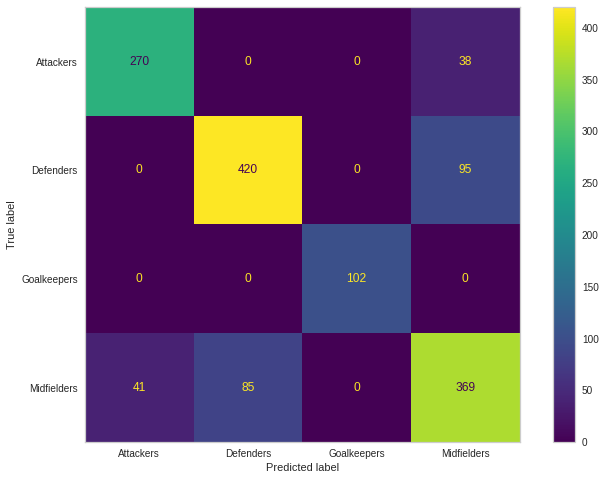

In [147]:
cf_matrix = confusion_matrix(y_train, svm_train_pred)
cmd = ConfusionMatrixDisplay(cf_matrix, display_labels=['Attackers', 'Defenders', 'Goalkeepers', 'Midfielders'])

fig, ax = plt.subplots(figsize=(12,8))
cmd.plot(ax=ax)
plt.grid(False)
plt.show()

In [148]:
svm_test_pred = gs.predict(X_test_sc)

Niestety, znowu zachodzi przeuczenie. Dokładność modelu spada o 0,07.

In [149]:
print(classification_report(le.inverse_transform(y_test), le.inverse_transform(svm_test_pred), zero_division=1))

              precision    recall  f1-score   support

    Attacker       0.80      0.76      0.78       154
    Defender       0.77      0.79      0.78       257
  Goalkeeper       1.00      1.00      1.00        51
  Midfielder       0.65      0.65      0.65       247

    accuracy                           0.75       709
   macro avg       0.80      0.80      0.80       709
weighted avg       0.75      0.75      0.75       709



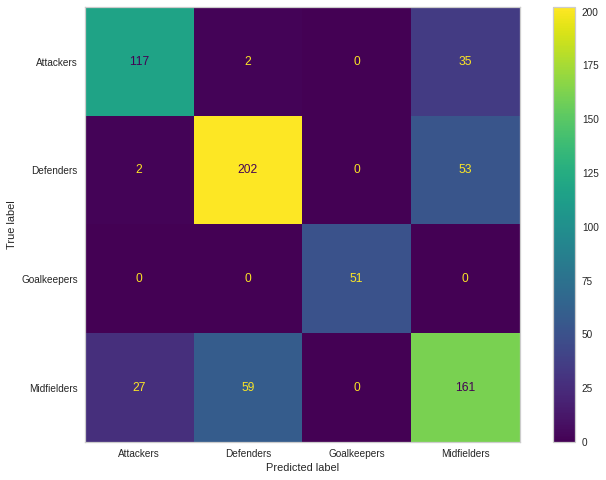

In [150]:
cf_matrix = confusion_matrix(y_test, svm_test_pred)
cmd = ConfusionMatrixDisplay(cf_matrix, display_labels=['Attackers', 'Defenders', 'Goalkeepers', 'Midfielders'])

fig, ax = plt.subplots(figsize=(12,8))
cmd.plot(ax=ax)
plt.grid(False)
plt.show()

In [151]:
train_scores.append(svm_train_pred)

In [152]:
test_scores.append(svm_test_pred)

###Kernel wielomianowy.

Jak wyglądać będzie klasyfikacja przy przetestowaniu tych samych parametrów kernela wielomianowego?

In [153]:
params = {'C': [0.01, 1, 2, 10, 25, 50, 100], 'degree': [1,2,3]}
svc = SVC(probability=True, kernel='poly')

gs = GridSearchCV(svc, param_grid=params, cv=10, verbose=10)
gs.fit(X_train_sc, y_train)
poly_svm_train_pred = gs.predict(X_train_sc)

Fitting 10 folds for each of 21 candidates, totalling 210 fits
[CV 1/10; 1/21] START C=0.01, degree=1..........................................
[CV 1/10; 1/21] END ...........C=0.01, degree=1;, score=0.472 total time=   0.4s
[CV 2/10; 1/21] START C=0.01, degree=1..........................................
[CV 2/10; 1/21] END ...........C=0.01, degree=1;, score=0.507 total time=   0.4s
[CV 3/10; 1/21] START C=0.01, degree=1..........................................
[CV 3/10; 1/21] END ...........C=0.01, degree=1;, score=0.507 total time=   0.4s
[CV 4/10; 1/21] START C=0.01, degree=1..........................................
[CV 4/10; 1/21] END ...........C=0.01, degree=1;, score=0.493 total time=   0.4s
[CV 5/10; 1/21] START C=0.01, degree=1..........................................
[CV 5/10; 1/21] END ...........C=0.01, degree=1;, score=0.514 total time=   0.4s
[CV 6/10; 1/21] START C=0.01, degree=1..........................................
[CV 6/10; 1/21] END ...........C=0.01, degree=

Współczynnik C równy 25, pierwszy stopień i podobny wynik estymowany do poprzednich klasyfikatorów - tak przewiduje GridSearchCV.

In [154]:
print(gs.best_params_)
print(gs.best_estimator_)
print(gs.best_score_)

{'C': 25, 'degree': 1}
SVC(C=25, degree=1, kernel='poly', probability=True)
0.7964788732394367


Tak jak w poprzednich wypadkach, większych różnic brak. Uwagi dot. poprzednich modeli w całości można podtrzymać. Odchylenia w poszczególnych rekordach pozostają w granicach błędu statystycznego.

In [155]:
print(classification_report(le.inverse_transform(y_train), le.inverse_transform(poly_svm_train_pred), zero_division=1))

              precision    recall  f1-score   support

    Attacker       0.87      0.86      0.86       308
    Defender       0.82      0.81      0.81       515
  Goalkeeper       1.00      1.00      1.00       102
  Midfielder       0.73      0.74      0.73       495

    accuracy                           0.81      1420
   macro avg       0.85      0.85      0.85      1420
weighted avg       0.81      0.81      0.81      1420



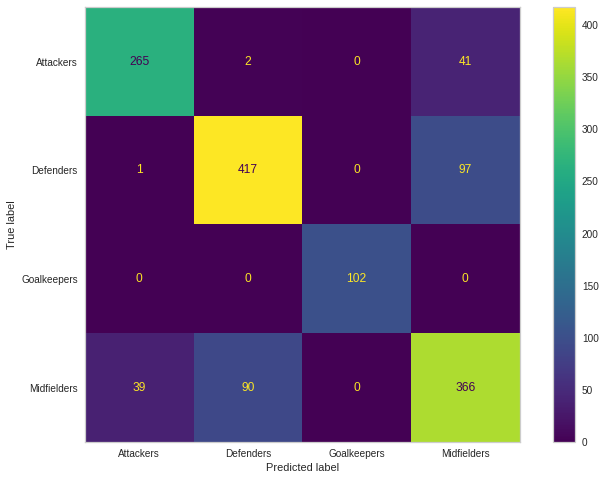

In [156]:
cf_matrix = confusion_matrix(y_train, poly_svm_train_pred)
cmd = ConfusionMatrixDisplay(cf_matrix, display_labels=['Attackers', 'Defenders', 'Goalkeepers', 'Midfielders'])

fig, ax = plt.subplots(figsize=(12,8))
cmd.plot(ax=ax)
plt.grid(False)
plt.show()

In [157]:
poly_svm_test_pred = gs.predict(X_test_sc)

Niestety, również bolączką tego modelu jest overfitting. Wszystkie metryki odnotowały wyraźny spadek, modelowi zdarzyło się również błędne przypisanie bramkarza jako napastnika.

In [158]:
print(classification_report(le.inverse_transform(y_test), le.inverse_transform(poly_svm_test_pred), zero_division=1))

              precision    recall  f1-score   support

    Attacker       0.80      0.76      0.78       154
    Defender       0.78      0.79      0.78       257
  Goalkeeper       1.00      0.98      0.99        51
  Midfielder       0.65      0.68      0.67       247

    accuracy                           0.76       709
   macro avg       0.81      0.80      0.80       709
weighted avg       0.76      0.76      0.76       709



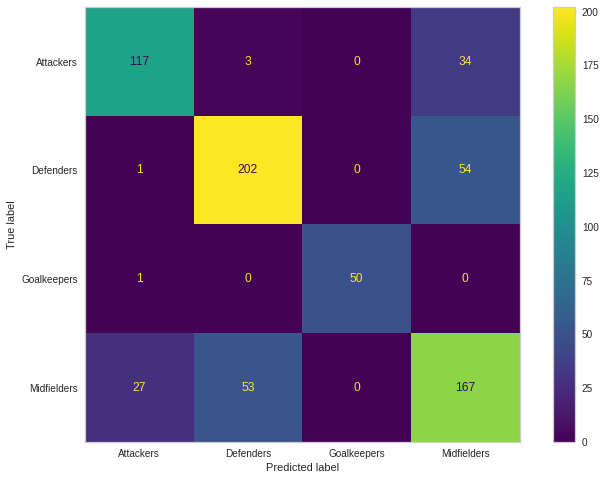

In [159]:
cf_matrix = confusion_matrix(y_test, poly_svm_test_pred)
cmd = ConfusionMatrixDisplay(cf_matrix, display_labels=['Attackers', 'Defenders', 'Goalkeepers', 'Midfielders'])

fig, ax = plt.subplots(figsize=(12,8))
cmd.plot(ax=ax)
plt.grid(False)
plt.show()

In [160]:
train_scores.append(poly_svm_train_pred)

In [161]:
test_scores.append(poly_svm_test_pred)

##Gaussowski NB.

Ponownie GridSearchCV dobierze dla gaussowskiego NB parametr wygładzania.

In [162]:
params = {'var_smoothing': np.linspace(0, 1, num=100)}
gnb = GaussianNB()
gs = GridSearchCV(gnb, param_grid=params, cv=10, verbose=10)
gs.fit(X_train_sc, y_train)
gnb_train_pred = gs.predict(X_train_sc)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
[CV 1/10; 1/100] START var_smoothing=0.0........................................
[CV 1/10; 1/100] END .........var_smoothing=0.0;, score=0.570 total time=   0.0s
[CV 2/10; 1/100] START var_smoothing=0.0........................................
[CV 2/10; 1/100] END .........var_smoothing=0.0;, score=0.662 total time=   0.0s
[CV 3/10; 1/100] START var_smoothing=0.0........................................
[CV 3/10; 1/100] END .........var_smoothing=0.0;, score=0.570 total time=   0.0s
[CV 4/10; 1/100] START var_smoothing=0.0........................................
[CV 4/10; 1/100] END .........var_smoothing=0.0;, score=0.556 total time=   0.0s
[CV 5/10; 1/100] START var_smoothing=0.0........................................
[CV 5/10; 1/100] END .........var_smoothing=0.0;, score=0.500 total time=   0.0s
[CV 6/10; 1/100] START var_smoothing=0.0........................................
[CV 6/10; 1/100] END .........var_smoothing=

Od samej wartości parametru bardziej interesujący jest estymowany wynik - wynosi bowiem poniżej 0,6.

In [163]:
print(gs.best_params_)
print(gs.best_estimator_)
print(gs.best_score_)

{'var_smoothing': 0.9797979797979799}
GaussianNB(var_smoothing=0.9797979797979799)
0.597887323943662


Jest to pierwszy (i zapewne jedyny) model, który tak drastycznie myli się w przewidywaniach. Spadek widoczny jest w każdej kategorii, nawet w stosunku do bramkarzy (1/3 błędnych przewidywań), model nie radzi sobie kompletnie z napastnikami, których poprawnie przypisał zaledwie 41/308.

In [164]:
print(classification_report(le.inverse_transform(y_train), le.inverse_transform(gnb_train_pred), zero_division=1))

              precision    recall  f1-score   support

    Attacker       0.89      0.13      0.23       308
    Defender       0.79      0.65      0.71       515
  Goalkeeper       1.00      0.67      0.80       102
  Midfielder       0.46      0.82      0.59       495

    accuracy                           0.60      1420
   macro avg       0.79      0.57      0.58      1420
weighted avg       0.71      0.60      0.57      1420



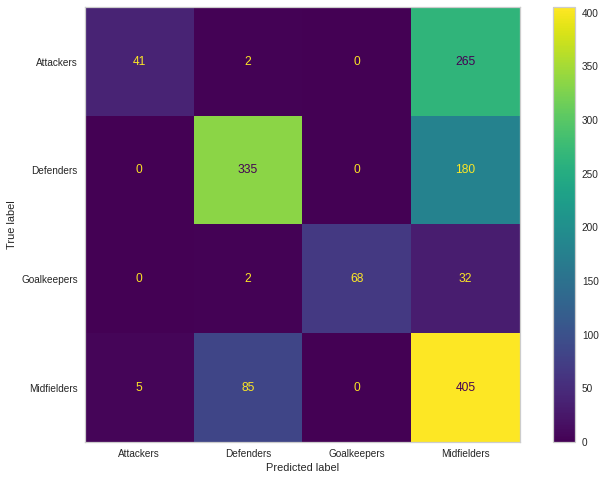

In [165]:
cf_matrix = confusion_matrix(y_train, gnb_train_pred)
cmd = ConfusionMatrixDisplay(cf_matrix, display_labels=['Attackers', 'Defenders', 'Goalkeepers', 'Midfielders'])

fig, ax = plt.subplots(figsize=(12,8))
cmd.plot(ax=ax)
plt.grid(False)
plt.show()

In [166]:
gnb_test_pred = gs.predict(X_test_sc)

Powyższa obserwacja uwydatnia się na zbiorze testowym. Przewidywanie bramkarzy daje rezultaty zbliżone do przewidywania na podstawie rzutu monetą.

In [167]:
print(classification_report(le.inverse_transform(y_test), le.inverse_transform(gnb_test_pred), zero_division=1))

              precision    recall  f1-score   support

    Attacker       0.86      0.12      0.21       154
    Defender       0.77      0.61      0.68       257
  Goalkeeper       1.00      0.53      0.69        51
  Midfielder       0.44      0.81      0.57       247

    accuracy                           0.57       709
   macro avg       0.77      0.52      0.54       709
weighted avg       0.69      0.57      0.54       709



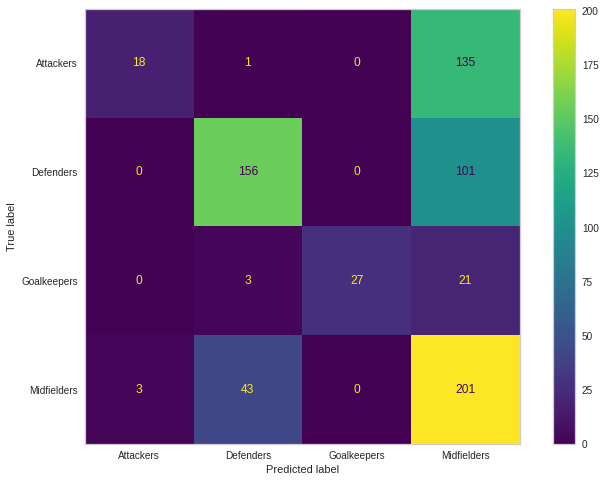

In [168]:
cf_matrix = confusion_matrix(y_test, gnb_test_pred)
cmd = ConfusionMatrixDisplay(cf_matrix, display_labels=['Attackers', 'Defenders', 'Goalkeepers', 'Midfielders'])

fig, ax = plt.subplots(figsize=(12,8))
cmd.plot(ax=ax)
plt.grid(False)
plt.show()

In [169]:
train_scores.append(gnb_train_pred)

In [170]:
test_scores.append(gnb_test_pred)

##Bagging.

Również lasowi losowemu przypiszemy podobne wartości, co w przypadku klasyfikacji binarnej.

In [171]:
params = {'max_depth': [3,4,5], 'min_samples_split': [2,4,6], 'min_samples_leaf': [2,3,4,5], 'n_estimators': [25,50,100]}
rfc = RandomForestClassifier()
gs = GridSearchCV(rfc, param_grid=params, cv=10, verbose=10)
gs.fit(X_train, y_train)
rfc_train_pred = gs.predict(X_train)

Fitting 10 folds for each of 108 candidates, totalling 1080 fits
[CV 1/10; 1/108] START max_depth=3, min_samples_leaf=2, min_samples_split=2, n_estimators=25
[CV 1/10; 1/108] END max_depth=3, min_samples_leaf=2, min_samples_split=2, n_estimators=25;, score=0.648 total time=   0.1s
[CV 2/10; 1/108] START max_depth=3, min_samples_leaf=2, min_samples_split=2, n_estimators=25
[CV 2/10; 1/108] END max_depth=3, min_samples_leaf=2, min_samples_split=2, n_estimators=25;, score=0.768 total time=   0.1s
[CV 3/10; 1/108] START max_depth=3, min_samples_leaf=2, min_samples_split=2, n_estimators=25
[CV 3/10; 1/108] END max_depth=3, min_samples_leaf=2, min_samples_split=2, n_estimators=25;, score=0.711 total time=   0.2s
[CV 4/10; 1/108] START max_depth=3, min_samples_leaf=2, min_samples_split=2, n_estimators=25
[CV 4/10; 1/108] END max_depth=3, min_samples_leaf=2, min_samples_split=2, n_estimators=25;, score=0.761 total time=   0.1s
[CV 5/10; 1/108] START max_depth=3, min_samples_leaf=2, min_samples

Wyniki są słabsze od poprzednich obserwacji (ok. 0,77), na co składają się: głębokość drzewa: 5, minimalna wielkość liścia: 3, liczba obserwacji na liść: 2, a także minimalna liczba drzew w lesie: 100.

In [172]:
print(gs.best_params_)
print(gs.best_estimator_)
print(gs.best_score_)

{'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 100}
RandomForestClassifier(max_depth=5, min_samples_leaf=3)
0.7690140845070423


Na zbiorze testowym wyniki wyglądają jak dotąd najlepiej. Średnio ok. 3/4 pomocników została zaklasyfikowana poprawnie, co jest wynikiem powyżej średniej.

In [173]:
print(classification_report(le.inverse_transform(y_train), le.inverse_transform(rfc_train_pred), zero_division=1))

              precision    recall  f1-score   support

    Attacker       0.91      0.85      0.88       308
    Defender       0.81      0.84      0.83       515
  Goalkeeper       1.00      1.00      1.00       102
  Midfielder       0.74      0.75      0.74       495

    accuracy                           0.82      1420
   macro avg       0.87      0.86      0.86      1420
weighted avg       0.82      0.82      0.82      1420



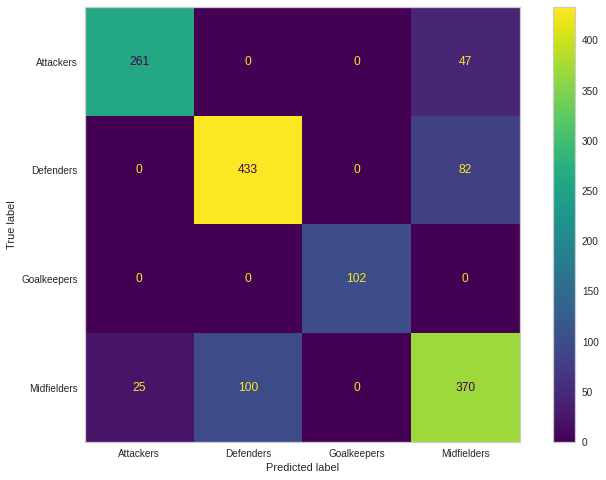

In [174]:
cf_matrix = confusion_matrix(y_train, rfc_train_pred)
cmd = ConfusionMatrixDisplay(cf_matrix, display_labels=['Attackers', 'Defenders', 'Goalkeepers', 'Midfielders'])

fig, ax = plt.subplots(figsize=(12,8))
cmd.plot(ax=ax)
plt.grid(False)
plt.show()

In [175]:
rfc_test_pred = gs.predict(X_test)

Niestety, okazało się, że model zmaga się ze znacznym overfittingiem. Dokładność spadła o 0,09 do poziomu 0,73, wszystkie metryki mają niższe wartości, nawet ta dotycząca bramkarzy.

In [176]:
print(classification_report(le.inverse_transform(y_test), le.inverse_transform(rfc_test_pred), zero_division=1))

              precision    recall  f1-score   support

    Attacker       0.83      0.71      0.77       154
    Defender       0.75      0.77      0.76       257
  Goalkeeper       1.00      0.98      0.99        51
  Midfielder       0.62      0.66      0.64       247

    accuracy                           0.73       709
   macro avg       0.80      0.78      0.79       709
weighted avg       0.74      0.73      0.74       709



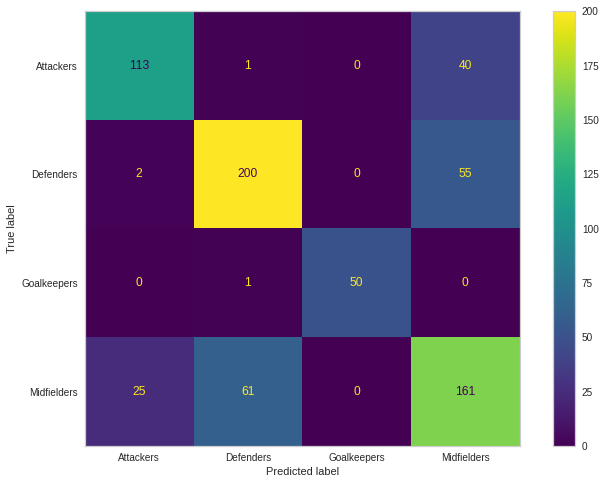

In [ ]:
cf_matrix = confusion_matrix(y_test, rfc_test_pred)
cmd = ConfusionMatrixDisplay(cf_matrix, display_labels=['Attackers', 'Defenders', 'Goalkeepers', 'Midfielders'])

fig, ax = plt.subplots(figsize=(12,8))
cmd.plot(ax=ax)
plt.grid(False)
plt.show()

In [177]:
train_scores.append(rfc_train_pred)

In [178]:
test_scores.append(rfc_test_pred)

##Boosting.

Kończymy modelowanie, wykorzystując AdaBoostClassifiera z tymi samymi parametrami, co w poprzednim jego zastosowaniu.

In [179]:
params = {'n_estimators': [75, 100], 'learning_rate': np.linspace(0.001, 1, num=15), 'algorithm': ['SAMME', 'SAMME.R']}
abc = AdaBoostClassifier()
gs = GridSearchCV(abc, param_grid=params, cv=10, verbose=10)
gs.fit(X_train_sc, y_train)
abc_train_pred = gs.predict(X_train_sc)

Fitting 10 folds for each of 60 candidates, totalling 600 fits
[CV 1/10; 1/60] START algorithm=SAMME, learning_rate=0.001, n_estimators=75.....
[CV 1/10; 1/60] END algorithm=SAMME, learning_rate=0.001, n_estimators=75;, score=0.535 total time=   0.4s
[CV 2/10; 1/60] START algorithm=SAMME, learning_rate=0.001, n_estimators=75.....
[CV 2/10; 1/60] END algorithm=SAMME, learning_rate=0.001, n_estimators=75;, score=0.528 total time=   0.4s
[CV 3/10; 1/60] START algorithm=SAMME, learning_rate=0.001, n_estimators=75.....
[CV 3/10; 1/60] END algorithm=SAMME, learning_rate=0.001, n_estimators=75;, score=0.542 total time=   0.4s
[CV 4/10; 1/60] START algorithm=SAMME, learning_rate=0.001, n_estimators=75.....
[CV 4/10; 1/60] END algorithm=SAMME, learning_rate=0.001, n_estimators=75;, score=0.563 total time=   0.4s
[CV 5/10; 1/60] START algorithm=SAMME, learning_rate=0.001, n_estimators=75.....
[CV 5/10; 1/60] END algorithm=SAMME, learning_rate=0.001, n_estimators=75;, score=0.528 total time=   0.

Wynik rzędu 0,7 nie zwiastuje modelu wysokiej jakości.

In [180]:
print(gs.best_params_)
print(gs.best_estimator_)
print(gs.best_score_)

{'algorithm': 'SAMME', 'learning_rate': 0.9286428571428571, 'n_estimators': 75}
AdaBoostClassifier(algorithm='SAMME', learning_rate=0.9286428571428571,
                   n_estimators=75)
0.6971830985915493


Okazuje się, że AdaBoostClassifier faktycznie spisuje się poniżej dotychczasowego standardu. Nie są to wyniki drastycznie słabe, ale - w stosunku do pozostałych klasyfikatorów - słabsze o ok. 0,1.

In [181]:
print(classification_report(le.inverse_transform(y_train), le.inverse_transform(abc_train_pred), zero_division=1))

              precision    recall  f1-score   support

    Attacker       0.84      0.72      0.78       308
    Defender       0.75      0.61      0.67       515
  Goalkeeper       1.00      0.99      1.00       102
  Midfielder       0.55      0.71      0.62       495

    accuracy                           0.70      1420
   macro avg       0.79      0.76      0.77      1420
weighted avg       0.72      0.70      0.70      1420



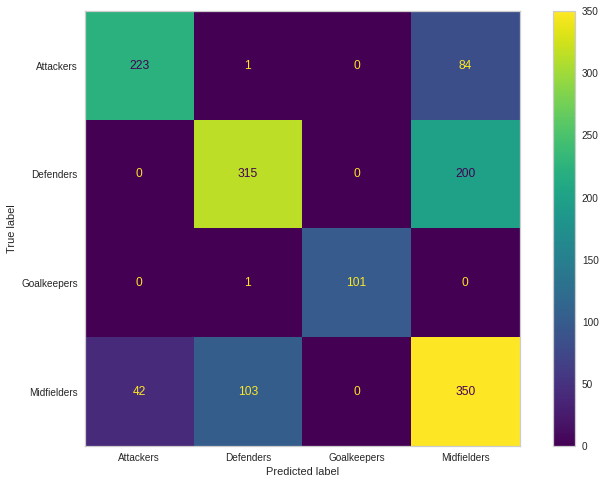

In [182]:
cf_matrix = confusion_matrix(y_train, abc_train_pred)
cmd = ConfusionMatrixDisplay(cf_matrix, display_labels=['Attackers', 'Defenders', 'Goalkeepers', 'Midfielders'])

fig, ax = plt.subplots(figsize=(12,8))
cmd.plot(ax=ax)
plt.grid(False)
plt.show()

In [183]:
abc_test_pred = gs.predict(X_test_sc)

Jeszcze słabiej jest w zbiorze testowym - model 2 razy błędnie przypisał bramkarzy. Podobne do zbioru treningowego zależności zachodzą w przewidywaniu pomocników i obrońców, wyraźnie niższe metryki mają przewidywania napastników.

In [184]:
print(classification_report(le.inverse_transform(y_test), le.inverse_transform(abc_test_pred), zero_division=1))

              precision    recall  f1-score   support

    Attacker       0.80      0.64      0.71       154
    Defender       0.74      0.60      0.66       257
  Goalkeeper       0.94      0.96      0.95        51
  Midfielder       0.54      0.70      0.61       247

    accuracy                           0.67       709
   macro avg       0.75      0.73      0.73       709
weighted avg       0.69      0.67      0.67       709



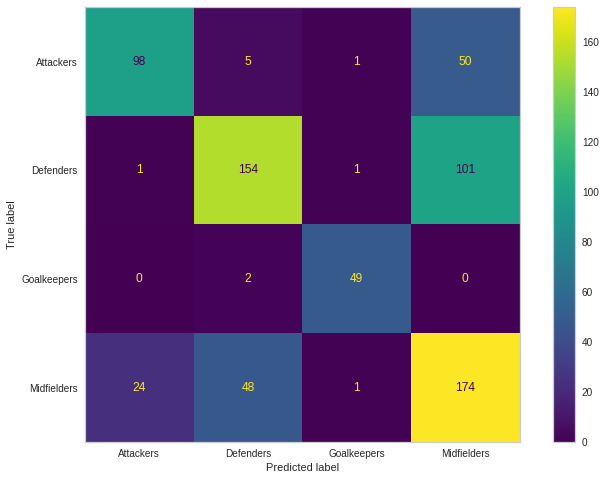

In [185]:
cf_matrix = confusion_matrix(y_test, abc_test_pred)
cmd = ConfusionMatrixDisplay(cf_matrix, display_labels=['Attackers', 'Defenders', 'Goalkeepers', 'Midfielders'])

fig, ax = plt.subplots(figsize=(12,8))
cmd.plot(ax=ax)
plt.grid(False)
plt.show()

In [186]:
train_scores.append(abc_train_pred)

In [187]:
test_scores.append(abc_test_pred)

##Podsumowanie.

Klasyfikacja wieloklasowa poszła niestety słabiej. Najlepsze modele przekraczały dokładność 0,8 na zbiorze treningowym i oscylowały w okolicach 0,75 na zbiorze testowym. Dla poszczególnych klasyfikatorów (z wyjątkiem gaussowskiego NB) nie było wyzwaniem dopasowanie bramkarzy, natomiast żaden nie radził sobie wystarczająco dobrze z pomocnikami. Można zrzucić to na karb specyfiki tej pozycji, której przedstawiciele co do zasady operują między obroną a atakiem, a często są im przypisane zadania wsparcia którejś z tych dwóch formacji.

Ponownie zbieramy listy wszystkich modeli (z obu zbiorów), wyliczamy metryki dokładności i F1 score, a następnie dalej przekształcamy celem porównania

In [196]:
scores = {'Training accuracy': [accuracy_score(y_train, i) for i in train_scores],
          'Test accuracy': [accuracy_score(y_test, i) for i in test_scores],
          'Training F1 score': [f1_score(y_train, i, average='weighted') for i in train_scores],
          'Test F1 score': [f1_score(y_test, i, average='weighted') for i in test_scores]}

In [197]:
scores = pd.DataFrame(scores, index=['Logistic Regression', 'SVM', 'Polynomial SVM',
                                     'Gaussian NB', 'Bagging', 'Boosting'])
scores['Accuracy difference'] = scores['Training accuracy'] - scores['Test accuracy']
scores['F1 difference'] = scores['Training F1 score'] - scores['Test F1 score']
scores

,Training accuracy,Test accuracy,Training F1 score,Test F1 score,Accuracy difference,F1 difference
Logistic Regression,0.804930,0.750353,0.804818,0.750753,0.054577,0.054066
SVM,0.817606,0.748942,0.817759,0.749140,0.068663,0.068620
Polynomial SVM,0.809859,0.755994,0.810171,0.756786,0.053865,0.053385
Gaussian NB,0.597887,0.566996,0.571540,0.538989,0.030892,0.032551
Bagging,0.821127,0.734838,0.821648,0.736384,0.086289,0.085265
Boosting,0.696479,0.669958,0.700807,0.673663,0.026521,0.027144


Wnioski:
- każdy z modeli zmaga się z problemem dopasowania do zbioru testowego. Najmniejsza różnica zachodzi w przypadku boostingu i gaussowskiego NB, jednakże klasyfikatory te są szalenie niedokładne,
- największym przeuczeniem charakteryzuje się bagging - pomimo najwyższego wyniku w zbiorze treningowym ma on - wskutek spadku metryki o niemal 0,09 punktu - jeden ze słabszych wyników na zbiorze testowym,
- ponownie najlepiej trzeba ocenić kernele; działają one szybko i - mimo istotnego spadku metryk - notują najlepsze rezultaty w zbiorze testowym. Podobne wyniki notuje regresja logistyczna, jednak jej duże wymagania obliczeniowe nie pozwalają jej traktować jako pierwszy wybór,
- potwierdza się słaba skuteczność gaussowskiego NB - modele bayesowskie nie wychwytują zależności między danymi, stąd ich wykorzystanie przy tak dużym zbiorze danych numerycznych może mieć wyłącznie charakter edukacyjny,
- dla każdego niemal klasyfikatora (z wyjątkiem gaussowskiego NB) dokładność i metryka F1 mają podobne wartości. W wypadku klasyfikacji wieloklasowej można rozważyć naprzemienne stosowanie tych metryk dla określenia jakości modelu.